In [1]:
import sys 
import numpy as np 
import pandas as pd 
import scipy 
import matplotlib as mpl 
mpl.rcParams['figure.dpi'] = 400        # high res figures
import matplotlib.pyplot as plt 
%matplotlib inline 
import sklearn 
import xgboost as xgb
import shap 
import pickle 

### Test Set Analysis, Financial Insights, And Delivery To The Client

The interpretation of ROC AUC score is the probability that for a pair of samples, one positive other negative, the positive sample will have a higher predicted probability by the model than the negative sample. In otherwords, for all possible pairs of positive and negative samples in the dataset being assessed, the proportion of pairs where the positive sample has a higher model predicted probability than the negative sample is equivalent to the ROC AUC.

In [2]:
with open('intermediate_data/xgb_model_w_data.pkl', 'rb') as f:
    features_response, X_train_all, y_train_all,\
        X_test_all, y_test_all, xgb_model_4 = pickle.load(f)

In [3]:
# predictions for test set
test_set_pred_proba = xgb_model_4.predict_proba(X_test_all)[:,1]

In [5]:
from sklearn.metrics import roc_auc_score 

test_auc = roc_auc_score(y_test_all, test_set_pred_proba)
test_auc

0.7735528979671706

#### Distribution of Predicted Probability and Decile Chart

One way to show the effectiveness of our model is to look at model performance for different subsets of the population. One way is to break up the population into subsets using the model predictions and calculate the true default rate for each subset. In this way, our model predictions capture the risk associated with borrowers and we divide the customers into different subsets of risk and then calculate the actual default rate for each group. We use deciles, which as quantiles, bin our customers into (10) equal-size bins (not equal-width). 

Before our decile chart, we look at a histogram of the prediction probabilities on the test set and realize that most of our predictions are cluster in the range of [0,2] and another smaller cluster centered around 0.7 .

The decile chart clearly shows that the default risk increases with each decile where the riskiest 10% of borrowsers have a default rate close to 70%, but the least risky are below 10%. When a model is able to effectively distinguish groups of borrowers with consistently increasing default risk, the model is said to slope the population. The default rate is relatively flat across the lowest 5 to 7 deciles, likely because these observations are mostly clusteed in the range [0,0.2] of predicted risk.

Text(0, 0.5, 'Number of samples')

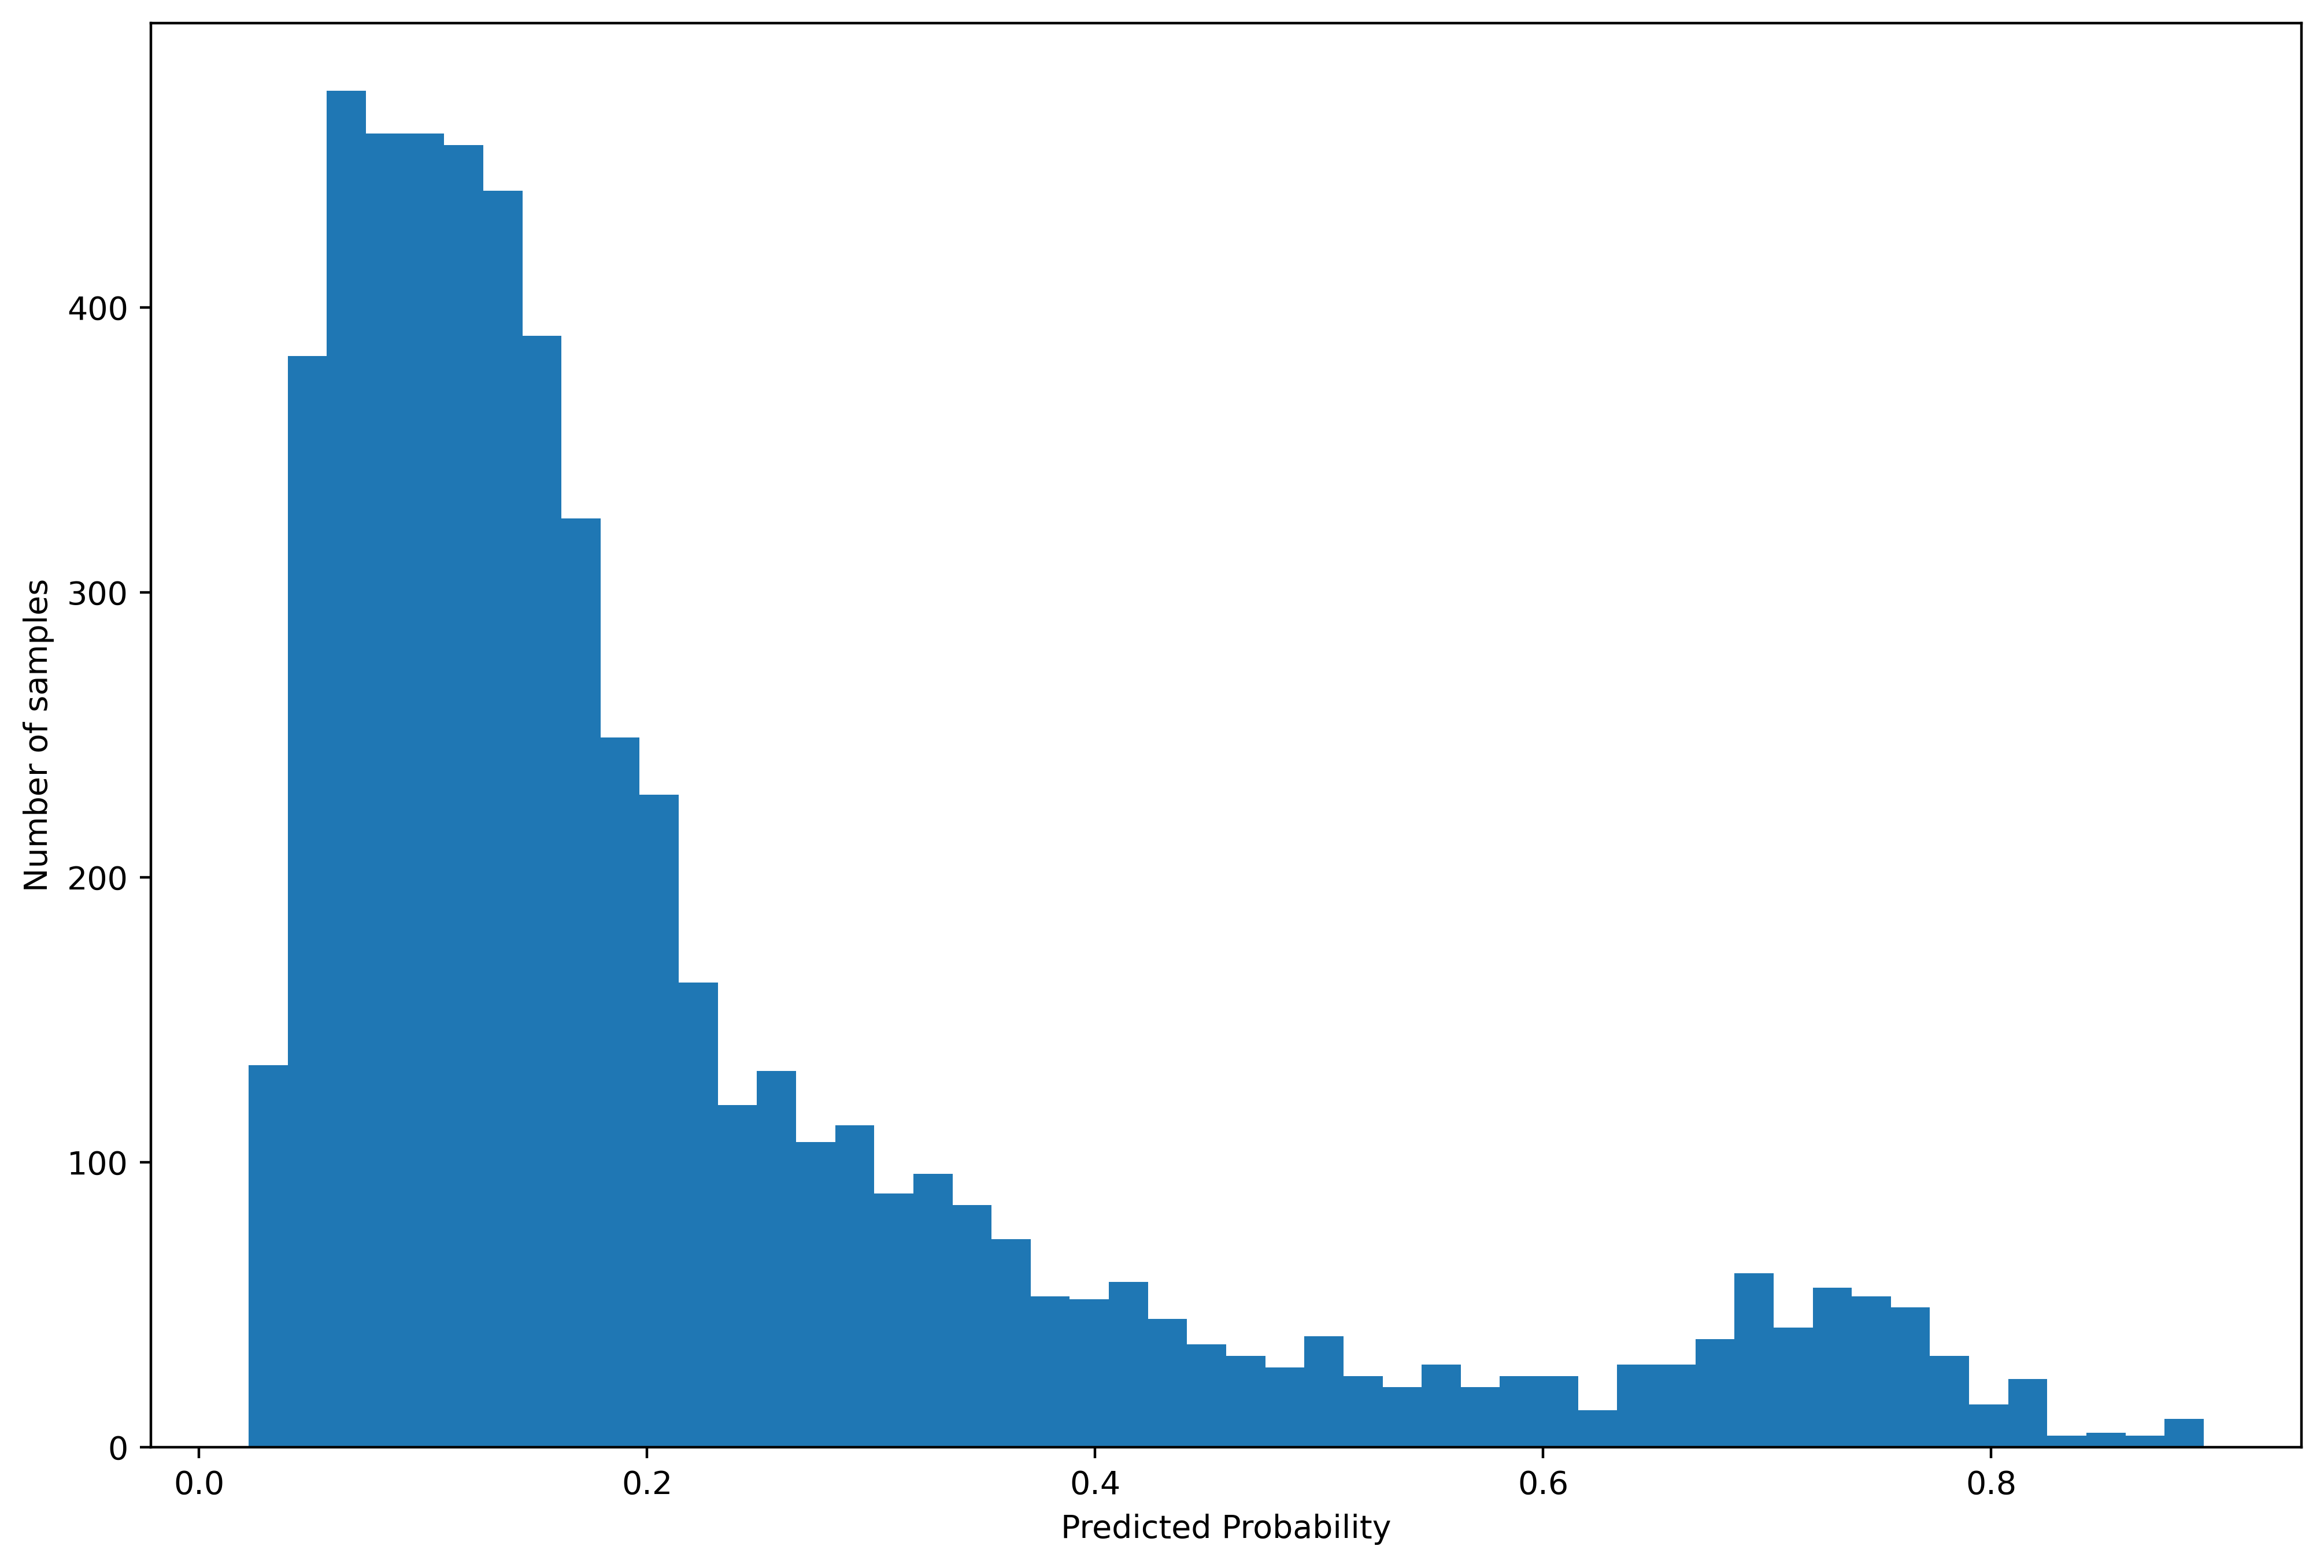

In [6]:
mpl.rcParams['figure.dpi'] = 400 
plt.figure(figsize=(12,8))
plt.hist(test_set_pred_proba, bins=50)
plt.xlabel('Predicted Probability')
plt.ylabel('Number of samples')

In [8]:
# Deciles chart
deciles, decile_bin_edges = pd.qcut(x=test_set_pred_proba,  #
                                    q=10,                   
                                    retbins=True)           # return bin edges in addition to decile labels

In [9]:
decile_bin_edges

array([0.02213463, 0.06000734, 0.08155108, 0.10424594, 0.12708404,
       0.15019046, 0.18111563, 0.23032923, 0.32210371, 0.52585585,
       0.89491451])

In [10]:
test_set_df = pd.DataFrame({'Predicted probability': test_set_pred_proba,
                            'Prediction decile': deciles, 
                            'Outcome': y_test_all})
test_set_df.head()

,Predicted probability,Prediction decile,Outcome
0,0.544556,"(0.526, 0.895]",0
1,0.621311,"(0.526, 0.895]",0
2,0.049883,"(0.0211, 0.06]",0
3,0.890924,"(0.526, 0.895]",1
4,0.272326,"(0.23, 0.322]",0


In [ ]:
# groupby decile labels and calculate actual default rate of each group
test_set_gr = test_set_df.groupby('Prediction decile')      # group by decile
gr_df = test_set_gr.agg({'Outcome': ['count', 'mean']})  # count outcome, mean outcome in each label
gr_df

Outcome          
                    count      mean
Prediction decile                  
(0.0211, 0.06]        594  0.045455
(0.06, 0.0816]        594  0.070707
(0.0816, 0.104]       594  0.099327
(0.104, 0.127]        593  0.112985
(0.127, 0.15]         594  0.116162
(0.15, 0.181]         594  0.171717
(0.181, 0.23]         593  0.195616
(0.23, 0.322]         594  0.282828
(0.322, 0.526]        594  0.392256
(0.526, 0.895]        594  0.676768

In [13]:
gr_df.columns   # multiindex column

MultiIndex([('Outcome', 'count'),
            ('Outcome',  'mean')],
           )

In [14]:
# accessing multiindex by tuples that identify each level
gr_df[('Outcome', 'count')]

Prediction decile
(0.0211, 0.06]     594
(0.06, 0.0816]     594
(0.0816, 0.104]    594
(0.104, 0.127]     593
(0.127, 0.15]      594
(0.15, 0.181]      594
(0.181, 0.23]      593
(0.23, 0.322]      594
(0.322, 0.526]     594
(0.526, 0.895]     594
Name: (Outcome, count), dtype: int64

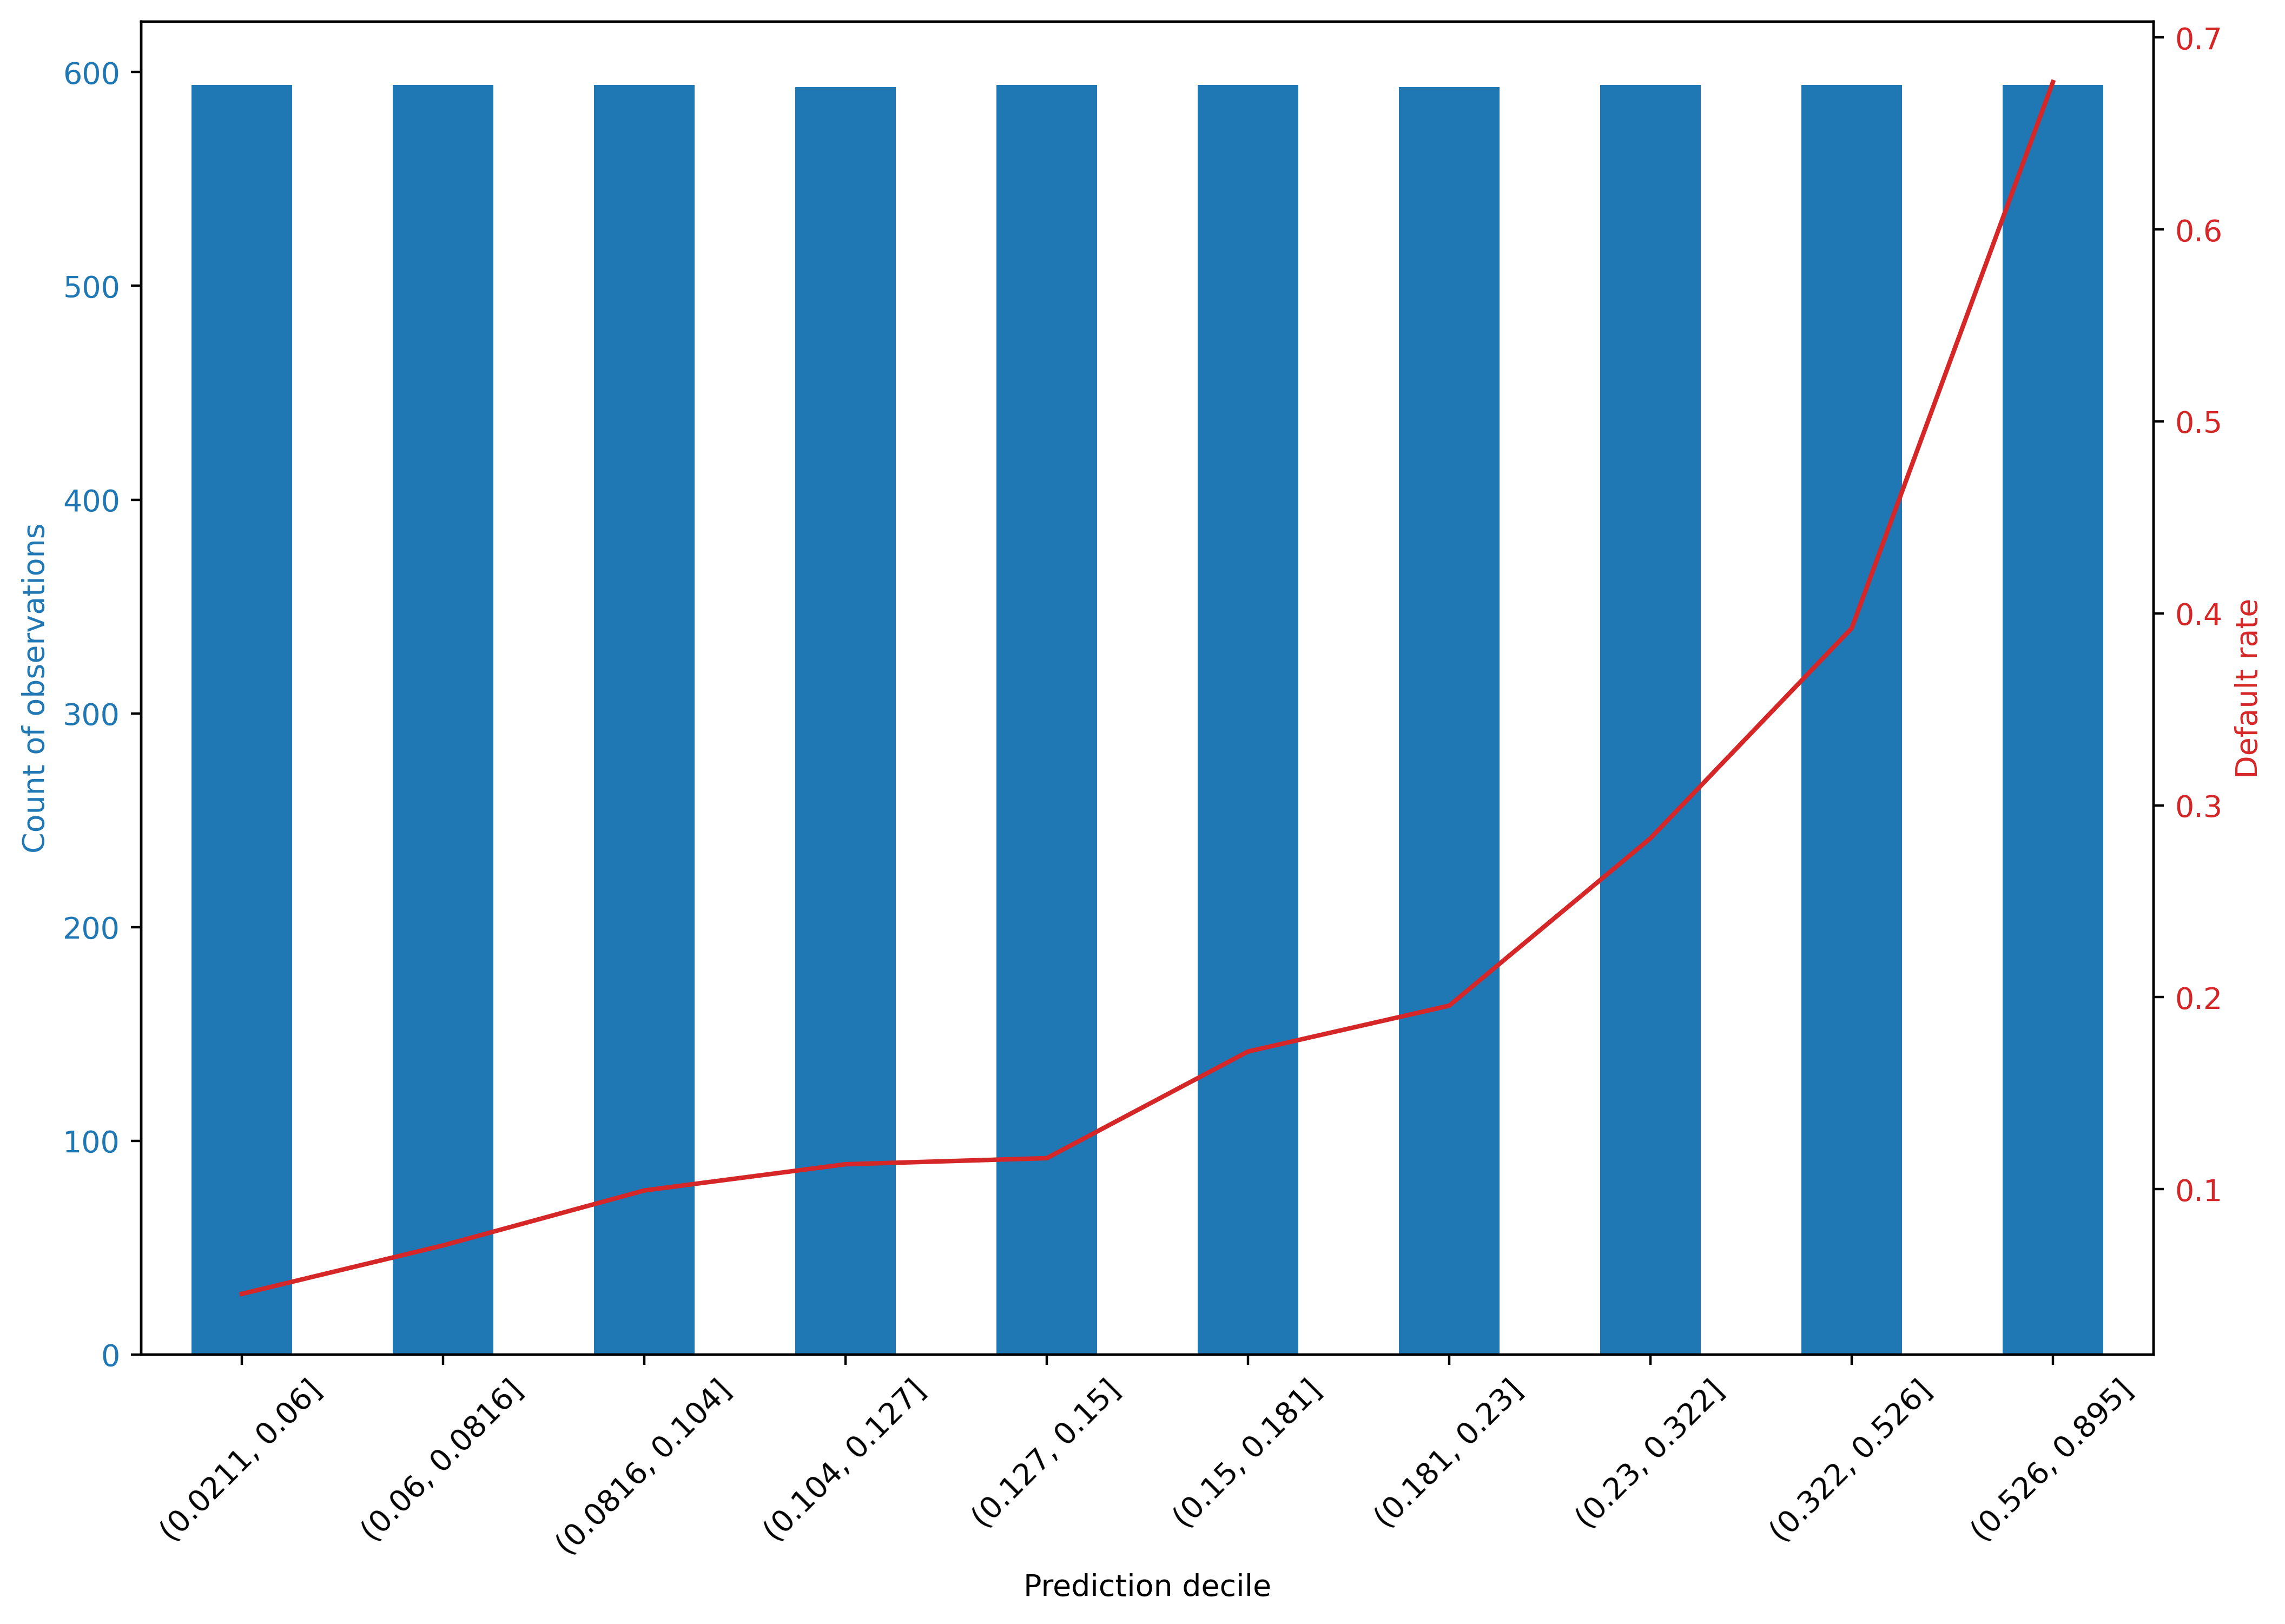

In [17]:
# decile chart showing count and true default rate in each bin using dual y-axis plot
plt.figure(figsize=(12,8))                                      

ax_1 = plt.axes()                                               # first set of axes for count data of deciles
color_1 = 'tab:blue' 
gr_df[('Outcome', 'count')].plot.bar(ax=ax_1, color=color_1)    # refer to multiindex column by levels' tuple
ax_1.set_ylabel('Count of observations', color=color_1) 
ax_1.tick_params(axis='y', labelcolor=color_1)
ax_1.tick_params(axis='x', labelrotation = 45)

ax_2 = ax_1.twinx()                                             # Create a twin Axes sharing the xaxis.
color_2 = 'tab:red'
gr_df[('Outcome', 'mean')].plot(ax=ax_2, color=color_2)
ax_2.set_ylabel('Default rate', color=color_2)
ax_2.tick_params(axis='y', labelcolor=color_2)


In [22]:
from sklearn.metrics import accuracy_score, f1_score

accuracy_score(y_test_all, xgb_model_4.predict(X_test_all))
f1_score(y_test_all, xgb_model_4.predict(X_test_all))

0.43609806990088684

#### Equal-Interval Chart

In addition to the decile chart, where the population was divided into equal-size bins, we want to look at equal-width binning of the population. For this we will use statistical concepts such as the standard error of the mean and the normal approximation of the binomial distribution. 

Basically, the variance of the sample mean is given by $\sigma^2_{\bar X}=\frac{\sigma^2}{n}$ where n is the sample size and $\sigma^2$ is the unobserved variance of a theoretical larger population. $\sigma^2$ can be estimated using the variance of the sample we observed. For binary variables, the sample variance can be calculated as $p(1-p)$ where $p$ is the proportion of successes. The variance of the sample mean is thus $\sigma^2_{\bar X}=\frac{p(1-p)}{n}$, this formula is also known as the normal approximation to the binomial distribution. We use this to create error bars on equal-interval chart of default rates for different model prediction bins. We expect the standard error to be larger for bins with smaller number of samples.

In [23]:
# Using pd.cut to create equal-width bins
equal_intervals, equal_interval_bin_edges = pd.cut(x=test_set_pred_proba,
                                                   bins=5,
                                                   retbins=True)

In [25]:
equal_interval_bin_edges

array([0.02126185, 0.1966906 , 0.37124658, 0.54580256, 0.72035853,
       0.89491451])

In [26]:
# check that intervals are equal-width
equal_interval_bin_edges[1:] - equal_interval_bin_edges[:-1]

array([0.17542876, 0.17455598, 0.17455598, 0.17455598, 0.17455598])

In [27]:
# dataframe of predicted probabilities, bin labels, and response variable
test_set_bins_df = pd.DataFrame({'Predicted probability': test_set_pred_proba,
                                 'Prediction bin': equal_intervals,
                                 'Outcome': y_test_all})
test_set_bins_df.head()

,Predicted probability,Prediction bin,Outcome
0,0.544556,"(0.371, 0.546]",0
1,0.621311,"(0.546, 0.72]",0
2,0.049883,"(0.0213, 0.197]",0
3,0.890924,"(0.72, 0.895]",1
4,0.272326,"(0.197, 0.371]",0


In [28]:
# Group by bin label and calculate default rate and sample count within bins
test_set_equal_gr = test_set_bins_df.groupby('Prediction bin')
gr_eq_df = test_set_equal_gr.agg({'Outcome': ['count', 'mean']})
gr_eq_df

Outcome          
                  count      mean
Prediction bin                   
(0.0213, 0.197]    3778  0.108788
(0.197, 0.371]     1207  0.257664
(0.371, 0.546]      389  0.465296
(0.546, 0.72]       312  0.608974
(0.72, 0.895]       252  0.761905

In [29]:
# due to different sample sizes in bins, we calculate standard error of the default rate
p = gr_eq_df[('Outcome', 'mean')].values        # default rate
n = gr_eq_df[('Outcome', 'count')].values       # sample sizes
std_err = np.sqrt(p*(1-p)/ n)                   # normal approximation to binomial distribution
std_err

array([0.00506582, 0.01258848, 0.02528987, 0.02762643, 0.02683029])

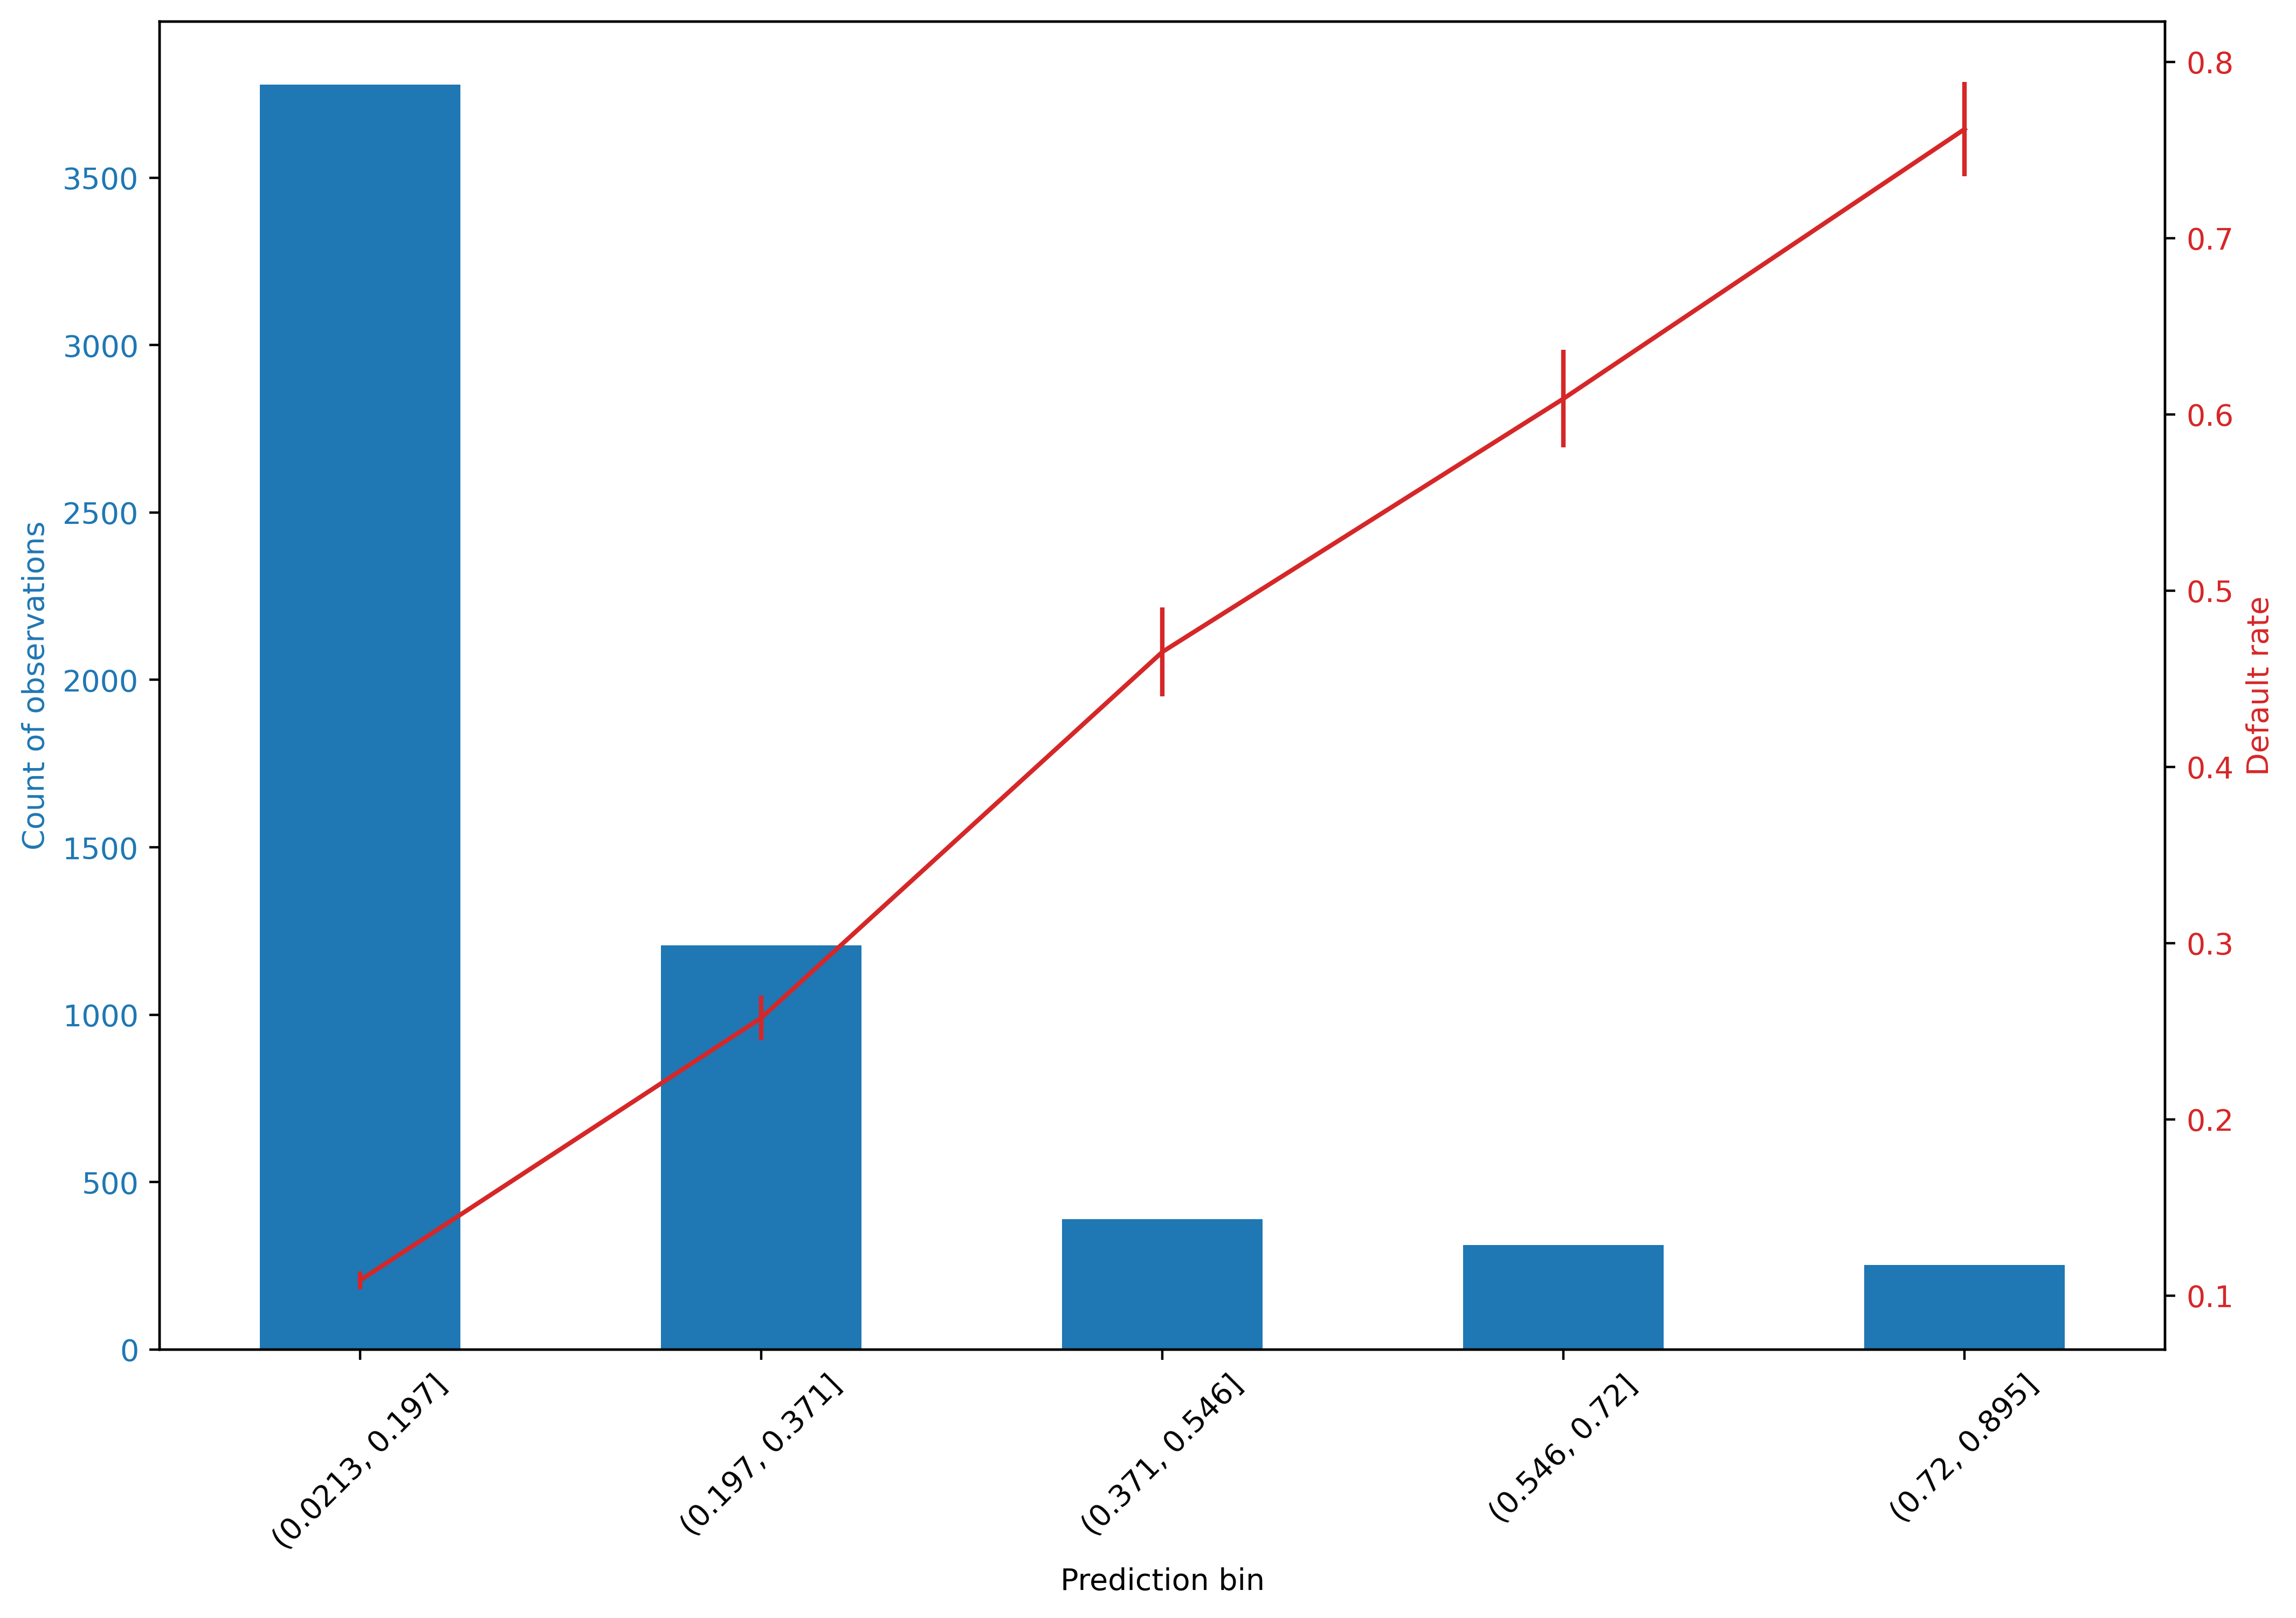

In [32]:
plt.figure(figsize=(12,8))
ax_1 = plt.axes()
color_1 = 'tab:blue'
gr_eq_df['Outcome', 'count'].plot.bar(ax=ax_1, color=color_1)
ax_1.set_ylabel('Count of observations', color=color_1)
ax_1.tick_params(axis='y', labelcolor=color_1)
ax_1.tick_params(axis='x', labelrotation=45)

ax_2 = ax_1.twinx()
color_2 = 'tab:red'
gr_eq_df[('Outcome', 'mean')].plot(ax=ax_2, color=color_2, yerr=std_err)
ax_2.set_ylabel('Default rate', color=color_2)
ax_2.tick_params(axis='y', labelcolor=color_2)

#### Calibration of Predicted Probabilities

The plot of default rates for equal-width bins increases by roughly the same amount from bin to bin, in contrast to the decile plot where default rate increases slowly at first, then more rapidly. The default rate also appears to be roughly the midpoint of the edges of predicted probability for each bin. This implies that default rate is similar to the average prediction in each bin. Thus, in addition to effectively ranking borrowers from low to high risk of default (as quantified by ROC), it also appears to accurately predict the probability of default.

Measuring how closely predicted probabilities match actual probabilities is the goal of calibrating probabilities. A standard measure for probability calibration is called expected calibration error (ECE).

$ECE=\Sigma_{i=1}^NF_i|o_i-e_i|$  

where index $i$ ranges from 1 to the number of bins ($N$), 

$F_i$ is the fraction of all samples falling in bin i, 

$o_i$ is the fraction of samples in bin $i$ that are positive (defaulters) and 

$e_i$ is the average probabilities within bin i.

So basically, for each bin, we take the absolute difference between the default rate (average default in bin),  the average predicted probabilites, weight it by the fraction of samples in the bin and sum the weighted probability deviation for all bins. Weighting by fraction of samples in bin is what makes it an expectation. 

Metrics like ECE can be monitored over time, after the model has been put in production. If ECE starts to increase, its a sign that the model is becoming less calibrated and may need to be retrained. Below, we apply ECE to the decile bins over the test set.

An intuitive way to examine the calibration of predicted probabilities is to plot the true default rate against the average of model predictions in each bin. We add a 1-1 line, which represents perfect calibration, as a point of reference.

In [35]:
# calculating ECE for decile bins of the test set
cal_df = test_set_gr.agg({'Outcome': ['count', 'mean'],         # sample size in bin, average default in bin
                          'Predicted probability': 'mean'})     # average predicted probability
cal_df

Outcome           Predicted probability
                    count      mean                  mean
Prediction decile                                        
(0.0211, 0.06]        594  0.045455              0.046931
(0.06, 0.0816]        594  0.070707              0.070745
(0.0816, 0.104]       594  0.099327              0.093163
(0.104, 0.127]        593  0.112985              0.115823
(0.127, 0.15]         594  0.116162              0.138656
(0.15, 0.181]         594  0.171717              0.165012
(0.181, 0.23]         593  0.195616              0.203106
(0.23, 0.322]         594  0.282828              0.273172
(0.322, 0.526]        594  0.392256              0.400159
(0.526, 0.895]        594  0.676768              0.693437

In [36]:
# calculating F, the fraction of samples in each bin, using the decile bins
F = cal_df[('Outcome', 'count')].values / y_test_all.shape[0]
F                                                               # F_i should be roughly 10% for all decile bins

array([0.10003368, 0.10003368, 0.10003368, 0.09986527, 0.10003368,
       0.10003368, 0.09986527, 0.10003368, 0.10003368, 0.10003368])

In [37]:
# calculating the ECE for the decile bins
ECE = np.sum(
    F * np.abs(
        cal_df[('Outcome', 'mean')] - cal_df[('Predicted probability', 'mean')]
    )
)
ECE

0.008144500702067469

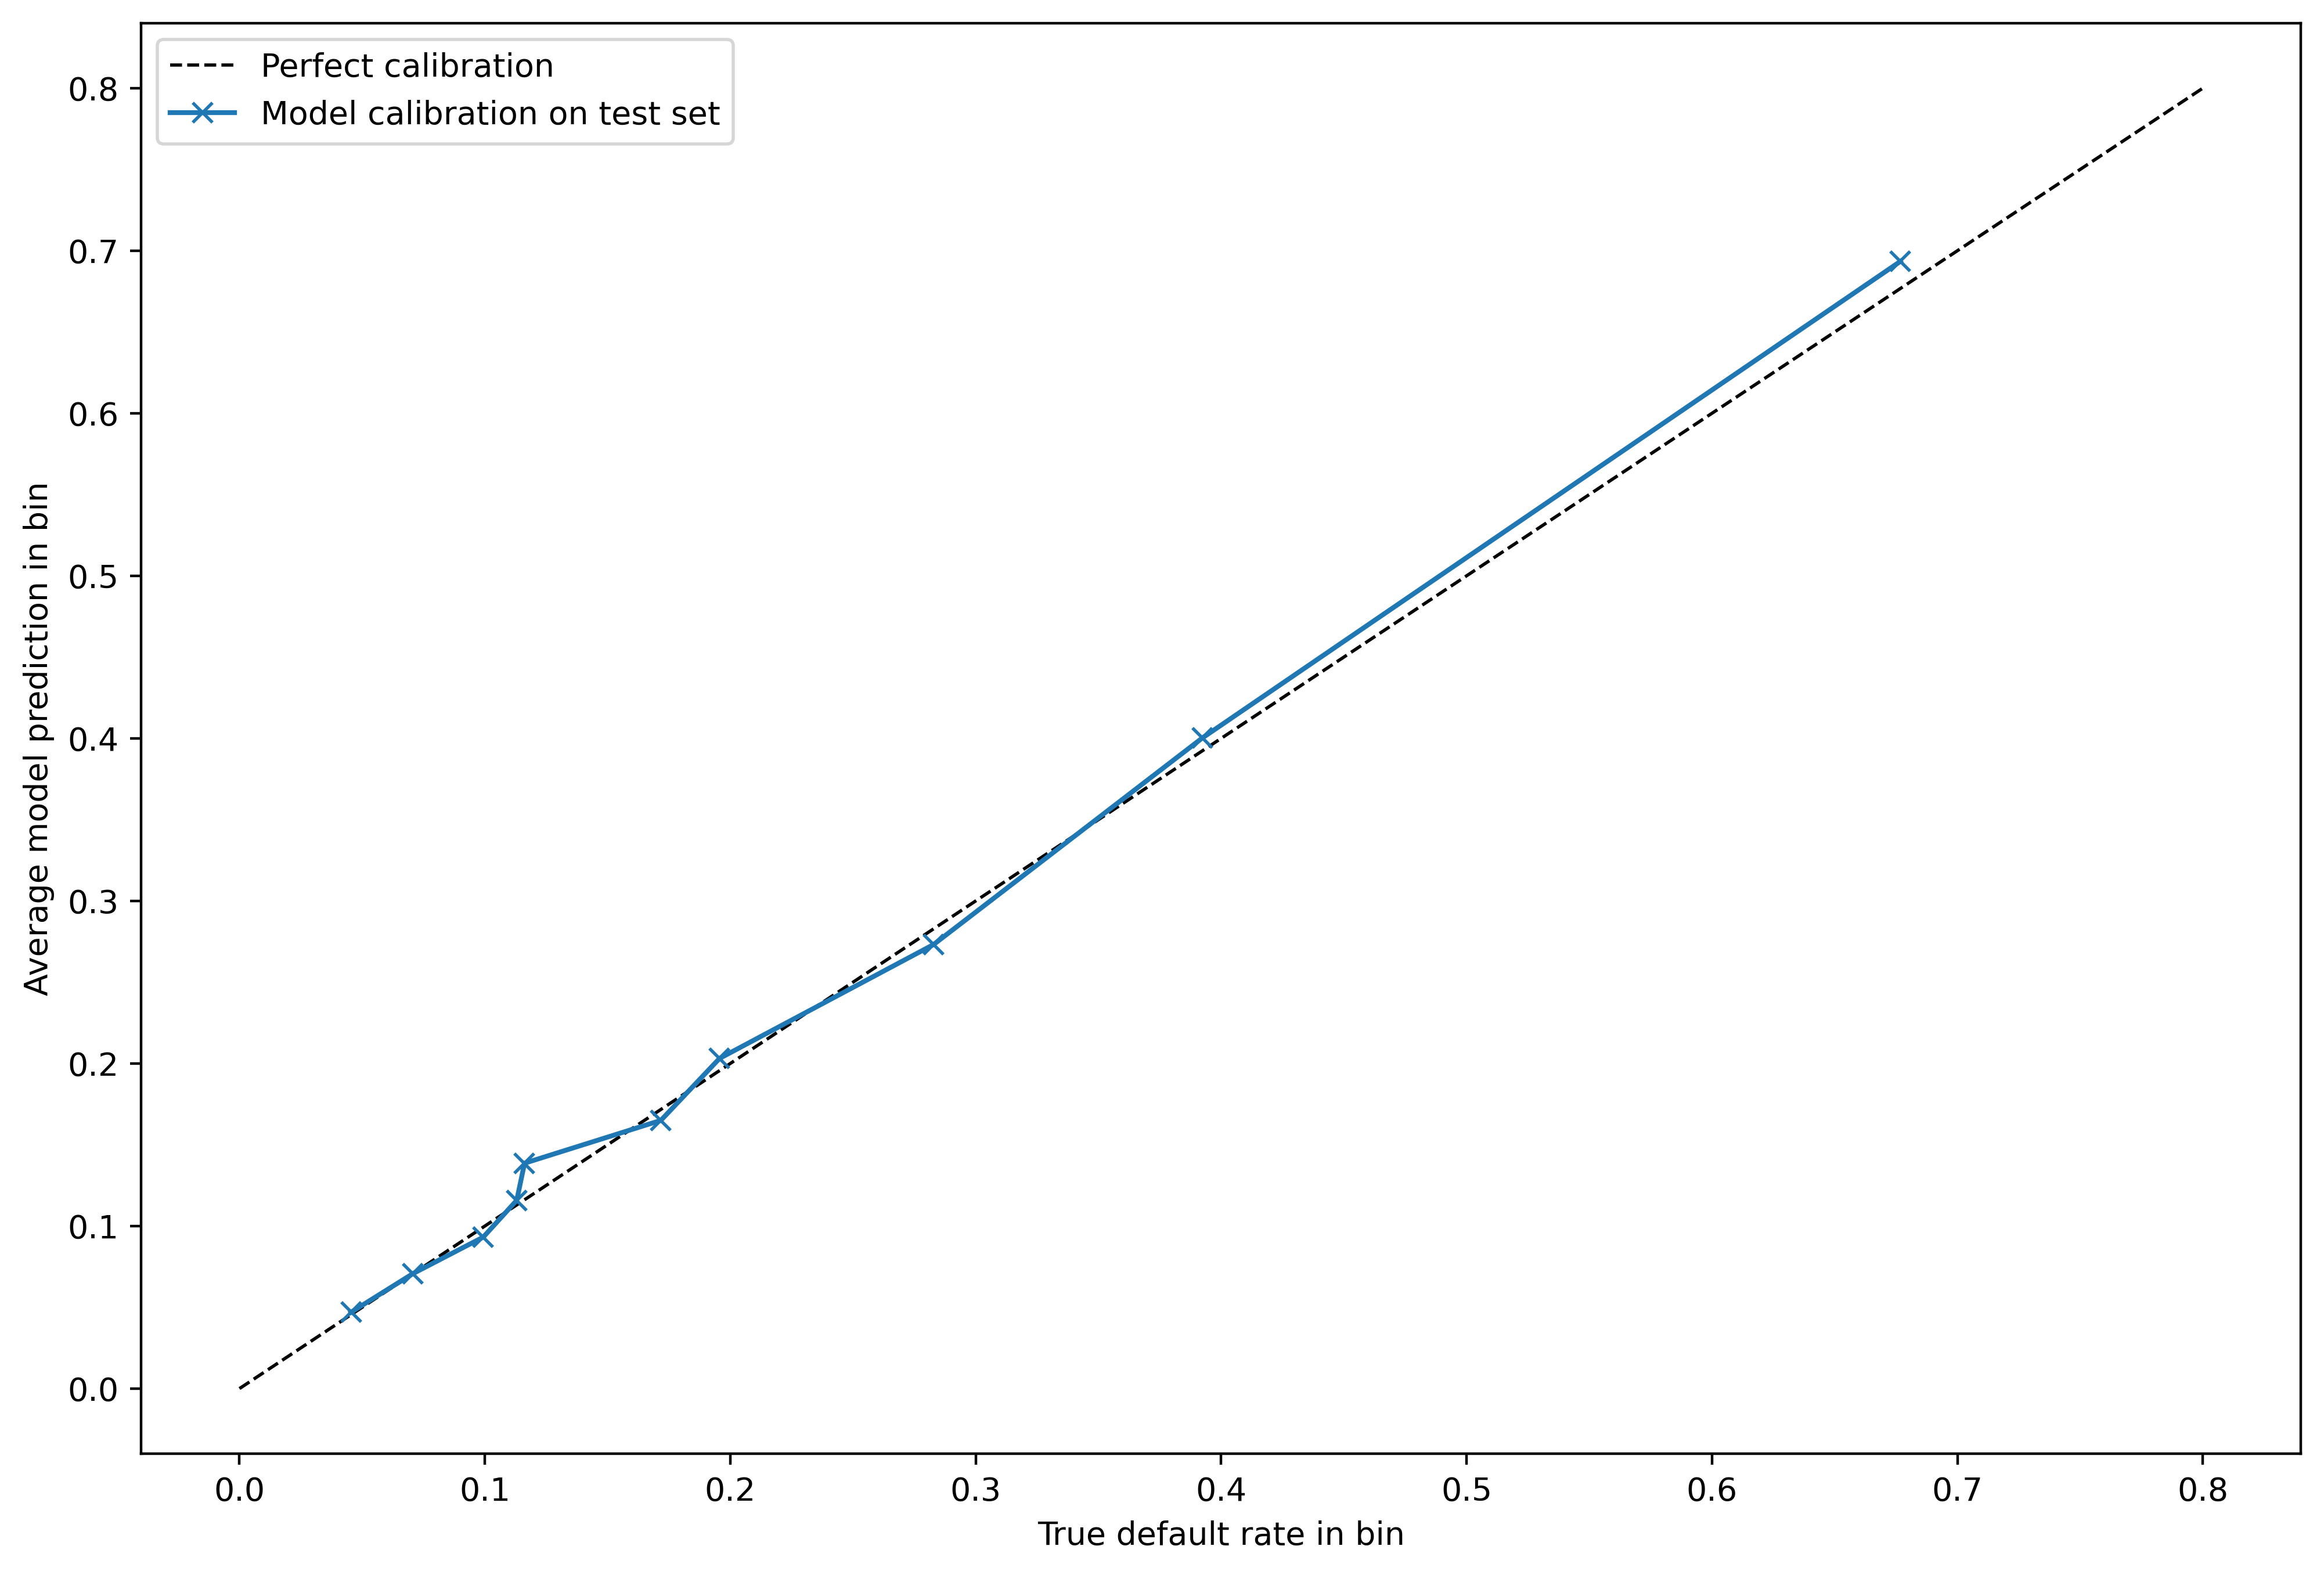

In [39]:
# plotting ingredients of ECE and 1-1 line
plt.figure(figsize=(12,8))
ax = plt.axes()
ax.plot([0, 0.8], [0, 0.8], 'k--', linewidth=1, 
        label='Perfect calibration') # 1-1 line (x1,x2),(y1,y2), x1=x2, y1=y2
ax.plot(cal_df[('Outcome', 'mean')],
        cal_df[('Predicted probability', 'mean')],
        marker='x',
        label='Model calibration on test set')
ax.set_xlabel('True default rate in bin')
ax.set_ylabel('Average model prediction in bin')
ax.legend()

#### Financial Analysis

The cornerstone of financial analysis of a model starts by looking at the business problem, and how our model may be used to solve it. Specifically our model is a binary classifier and the model outputs are predicted probabilities. If we can choose thresholds to segment customers into low/high risk or even low/mid/high risk, which would need two thresholds. 

In this case study, the client wants to offer credit counseling services to high risk customers. The potential benefits of successful counseling are that the amount of an account's monthly bill will be realized as savings if it was going to default (predicted) but instead didn't (actual), as a result of the counseling. Currently, monthly bills for accounts that default are reported as losses. The client would like the data scientist to help them decide which members to contact and offer credit counseling. If we can help narrow down the list of people who will be contacted for counseling, data scientists can help save them money by avoiding unnecessary and expensive contacts. The financial analysis can also help the client request a budget for the counseling program, if we can give them an idea of how many counseling sessions it would be worthwhile to offer.

For each threshold, there will be a different number of positive predictions, according to how many predicted probabilities are above that threshold. These correspond to accounts that are predicted to default. Each account that is predicted to default will receive a counseling phone call, which has a cost.

Savings are obtained when counseling is offered to the right account holders: those who would otherwise default. These are those positive predictions where the true value of the response variable is also positive, in other words, true positives.

Also note that these financial analysis are possible because of the test set which was set apart and only used for
providing an estimate of model performance on never seen data. This role of simulating never seen data allows us to run some analysis of potential savings, cost of investment etc. This is because we are able to simulate how new data will be used. Our model will output likelihoods that represent an account's risk of default. Those who have a higher than threshold likelihood of default will receive credit counseling phone calls (delivered by customer service) based on our model's output on the test set. Our total cost per threshold will be based on the number of accounts predicted as likely defaulters under each threshold value.

On the test set, we know that no all the accounts that were predicted as likely to default actually defaulted. That 
is, not every predicted accounts represented actual potential savings by using the model. The predicted accounts that actually defaulted represent actual potential savings. That is for each threshold, we find the predicted defaulters to gauge our upfront investment. Those predicted defaulters on the test set, that actually went on to default represent our potential savings. The maximum savings for any true positive is their respective bill amount, and since customers can pay anything from minimum payment, part payment or full balance payment, from historical data, we know how effectiveness of the program, that is the portion of bill amounts that are able to be recouped.
Thus to determine our total savings per threshold, we need the true positives, their bill amounts and the effectiveness ratio. Thus we have how much we would spend (predicted thresholds) and how much we would save (true positives bill amounts, weighted by effectiveness). 

We can get our net savings by subtracting our total cost from the total savings at each threshold. By this we select the threshold that will achieve the greatest savings as the threshold to use. 

Now remeber all this analysis is done on our test set, so we have to scale it by dividing our net savings per account and our upfront cost per account by dividing both net savings and upfront cost by the total number of accounts in the test set. So for a new batch of unseen data we can calculate the cost of the running our program on said dataset as well as expected savings based on the dataset size. So matching up with threshold values, we plot cost per account, upfront investment per account. We also plot the flag rate ie the  proportion of positive predictions, as well as the precision-recall curve.

As for the predictive capability embodied in the model, we can save the model to disk to be deployed in client's infrastructure. Alternatively, we can need to express predictive capability as SQL code either as mathematical equation (eg logistic regression coefficients) or if-then statements (from random forests). Software packages such as SKompiler exist to translate trained scikit-learn model to SQL code.

In [40]:
thresholds = np.linspace(0,1,101) # 101 linearly spaced points between 0 and 1, inclusive

In [42]:
features_response[5]                # estimate potential savings using last month's bill

'BILL_AMT1'

In [48]:
# financial analysis of model's impact on credit counseling program
cost_per_counseling = 7500   
effectiveness = 0.70                # counseling program isn't 100% effective (not everyone will listen)

# empty arrays to store analysis results
n_pos_pred = np.empty_like(thresholds)  # number of counselings at each level of investment
total_cost = np.empty_like(thresholds)  # different levels of investment (each threshold is a level)
n_true_pos = np.empty_like(thresholds)  # number of true positive, defaults prevented, 
total_savings = np.empty_like(thresholds)   # potential savings from preventing default

# characterize the possible costs and savings of the counseling program
counter = 0
for threshold in thresholds:
    # cost at threshold
    pos_pred = test_set_pred_proba > threshold  # boolean identity mask for predicted default under threshold
    n_pos_pred[counter] = sum(pos_pred)  # number of predicted default hence calls given under threshold, 
    total_cost[counter] = n_pos_pred[counter] * cost_per_counseling   # cost of calls under threshold

    # true positives at threshold
    true_pos = pos_pred & y_test_all.astype(bool)   # boolean identity mask for true positive
    n_true_pos[counter] = sum(true_pos)             # number of true positives; defaults correctly identified

    # anticipated savings
    total_savings[counter] = np.sum(
        true_pos.astype(int)                        # 1 for true positive, 0 otherwise 
        * X_test_all[:,5]                           # total bill amount of last year
        * effectiveness                             # we won't prevent every default or reach everyone
    )

    counter += 1

In [49]:
net_savings = total_savings - total_cost 

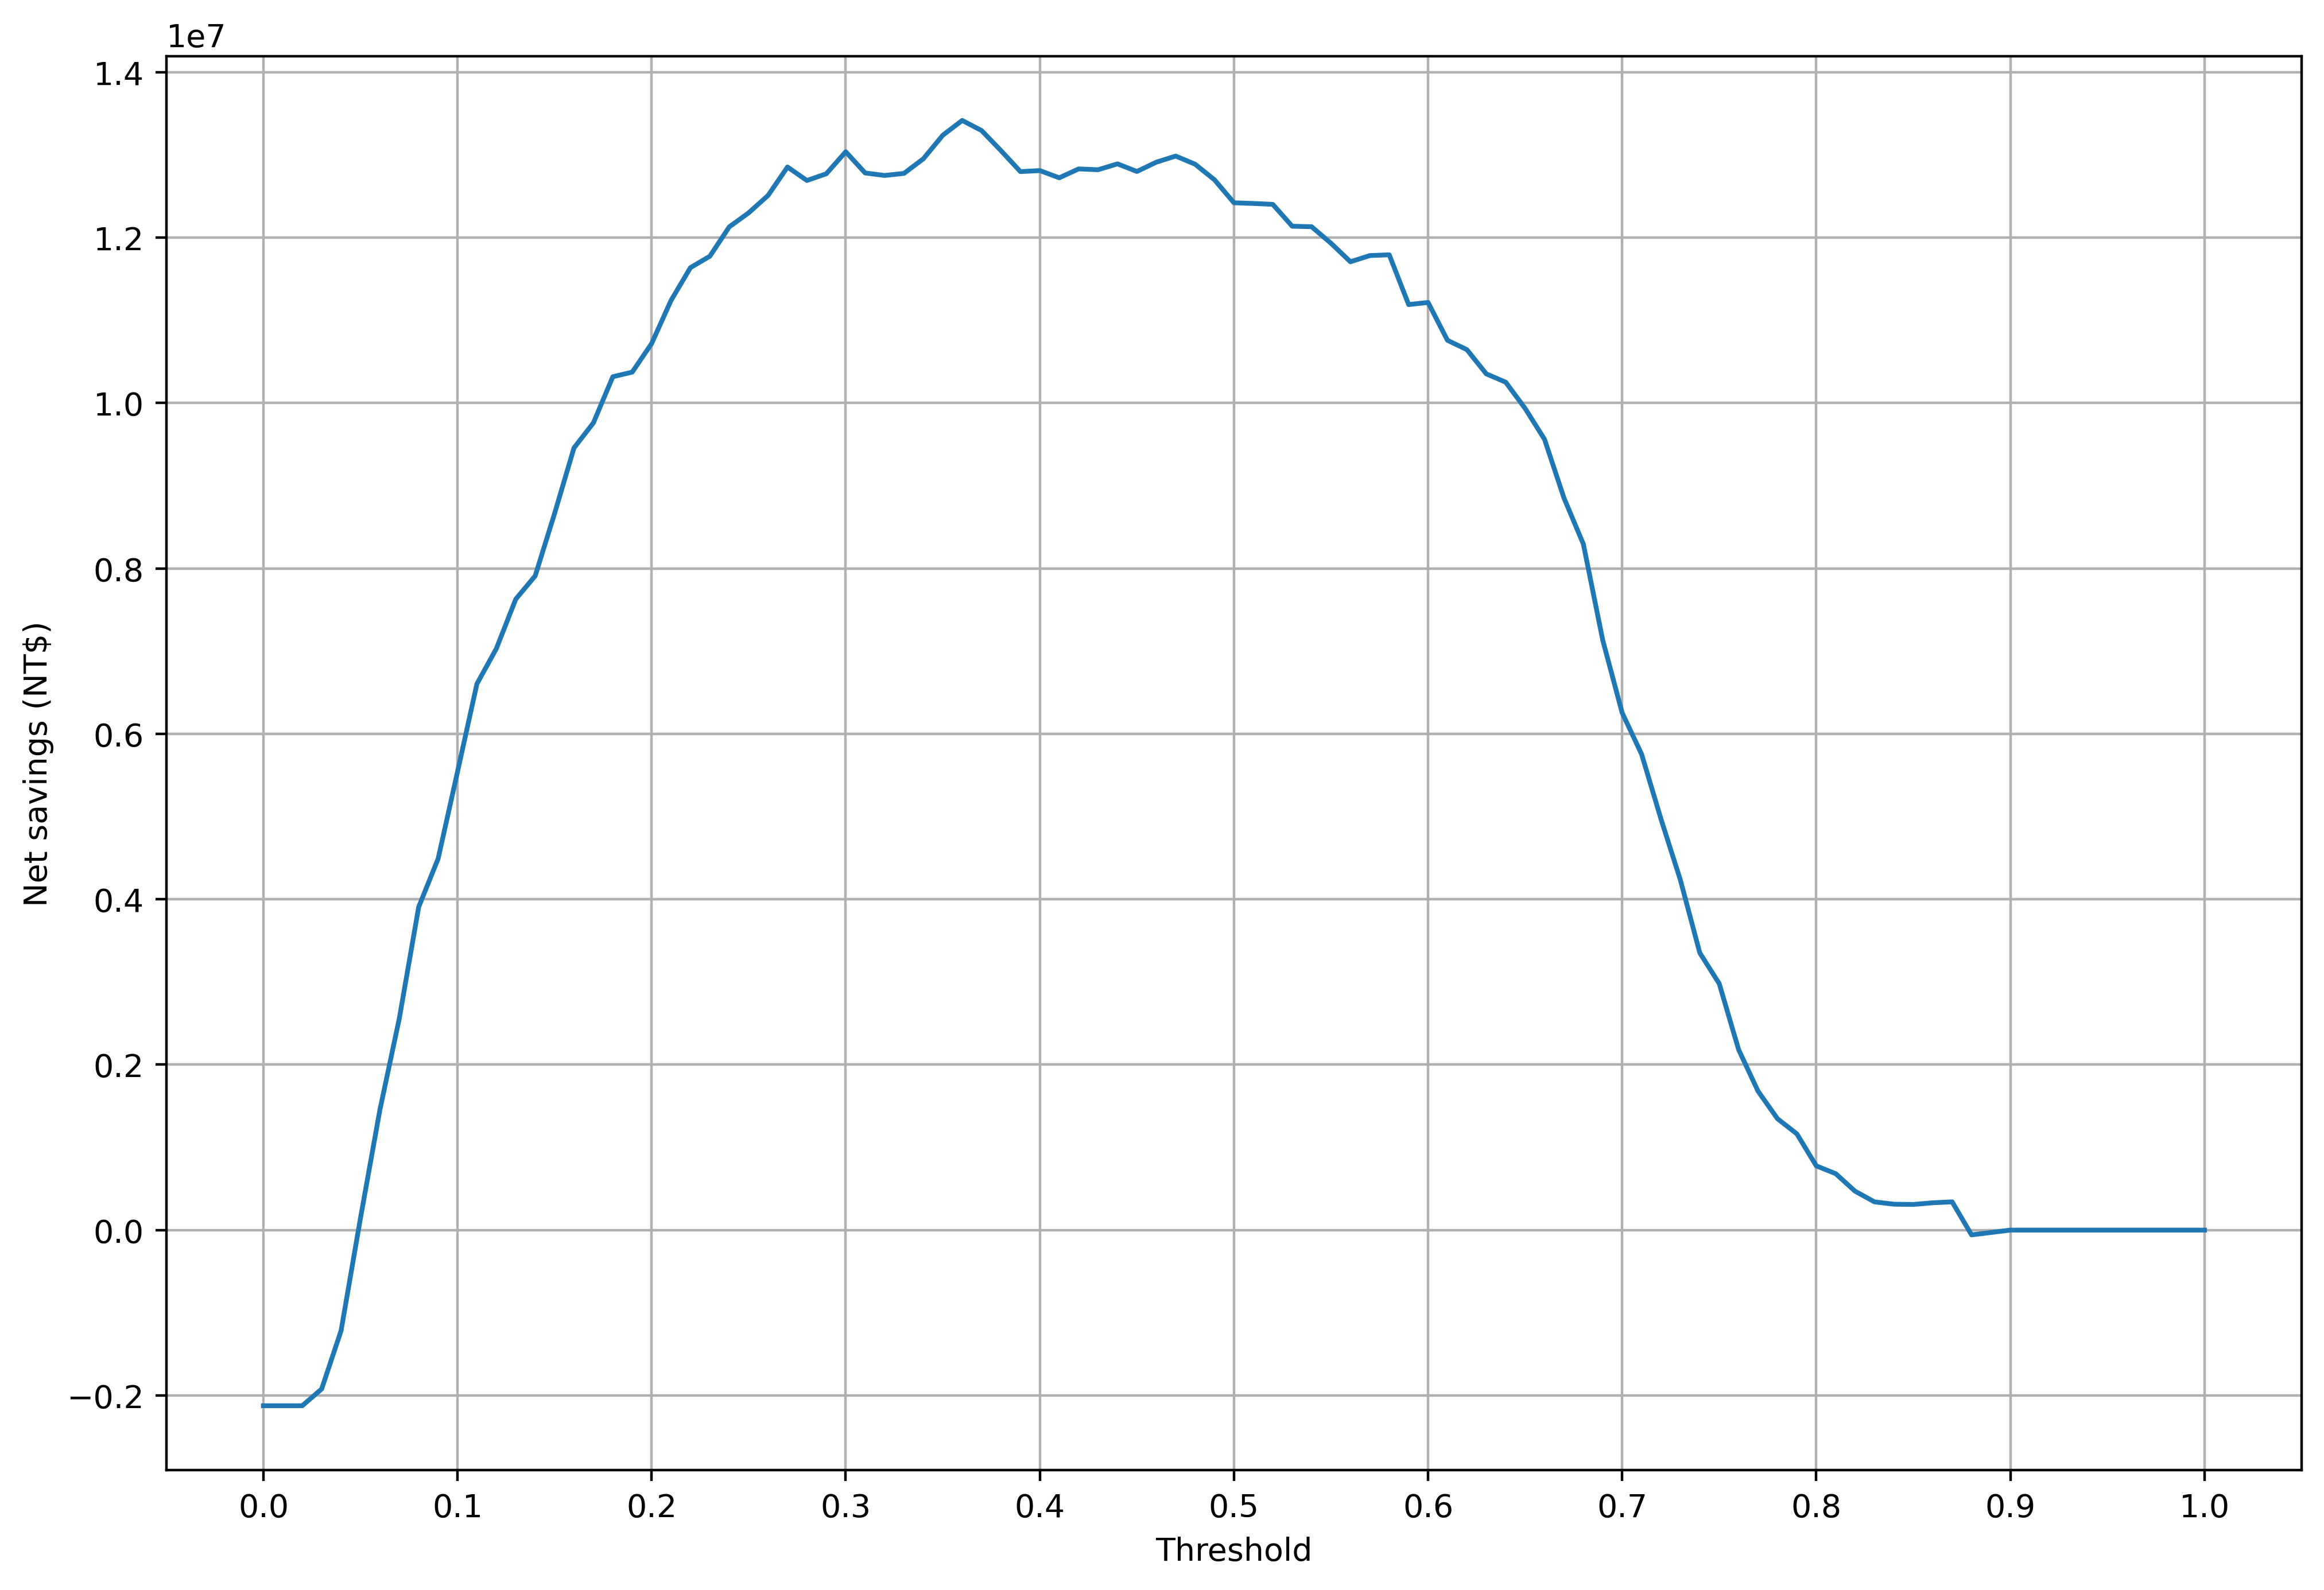

In [51]:
# Plot of net savings against thresholds
plt.figure(figsize=(12,8))
mpl.rcParams['figure.dpi'] = 400 
plt.plot(thresholds, net_savings)
plt.xlabel('Threshold')
plt.ylabel('Net savings (NT$)')
plt.xticks(np.linspace(0,1,11))
plt.grid(True)


In [52]:
# index of largest element of net savings
max_savings_ix = np.argmax(net_savings)
thresholds[max_savings_ix]

0.36

In [53]:
net_savings[max_savings_ix]

13415710.0

#### Deriving Financial Insights

In [54]:
cost_of_defaults = np.sum(y_test_all * X_test_all[:,5])
cost_of_defaults

60587763.0

In [55]:
net_savings[max_savings_ix] / cost_of_defaults

0.2214260658542551

In [56]:
net_savings[max_savings_ix] / len(y_test_all)

2259.2977433479286

Text(0, 0.5, 'Net savings per account (NT$)')

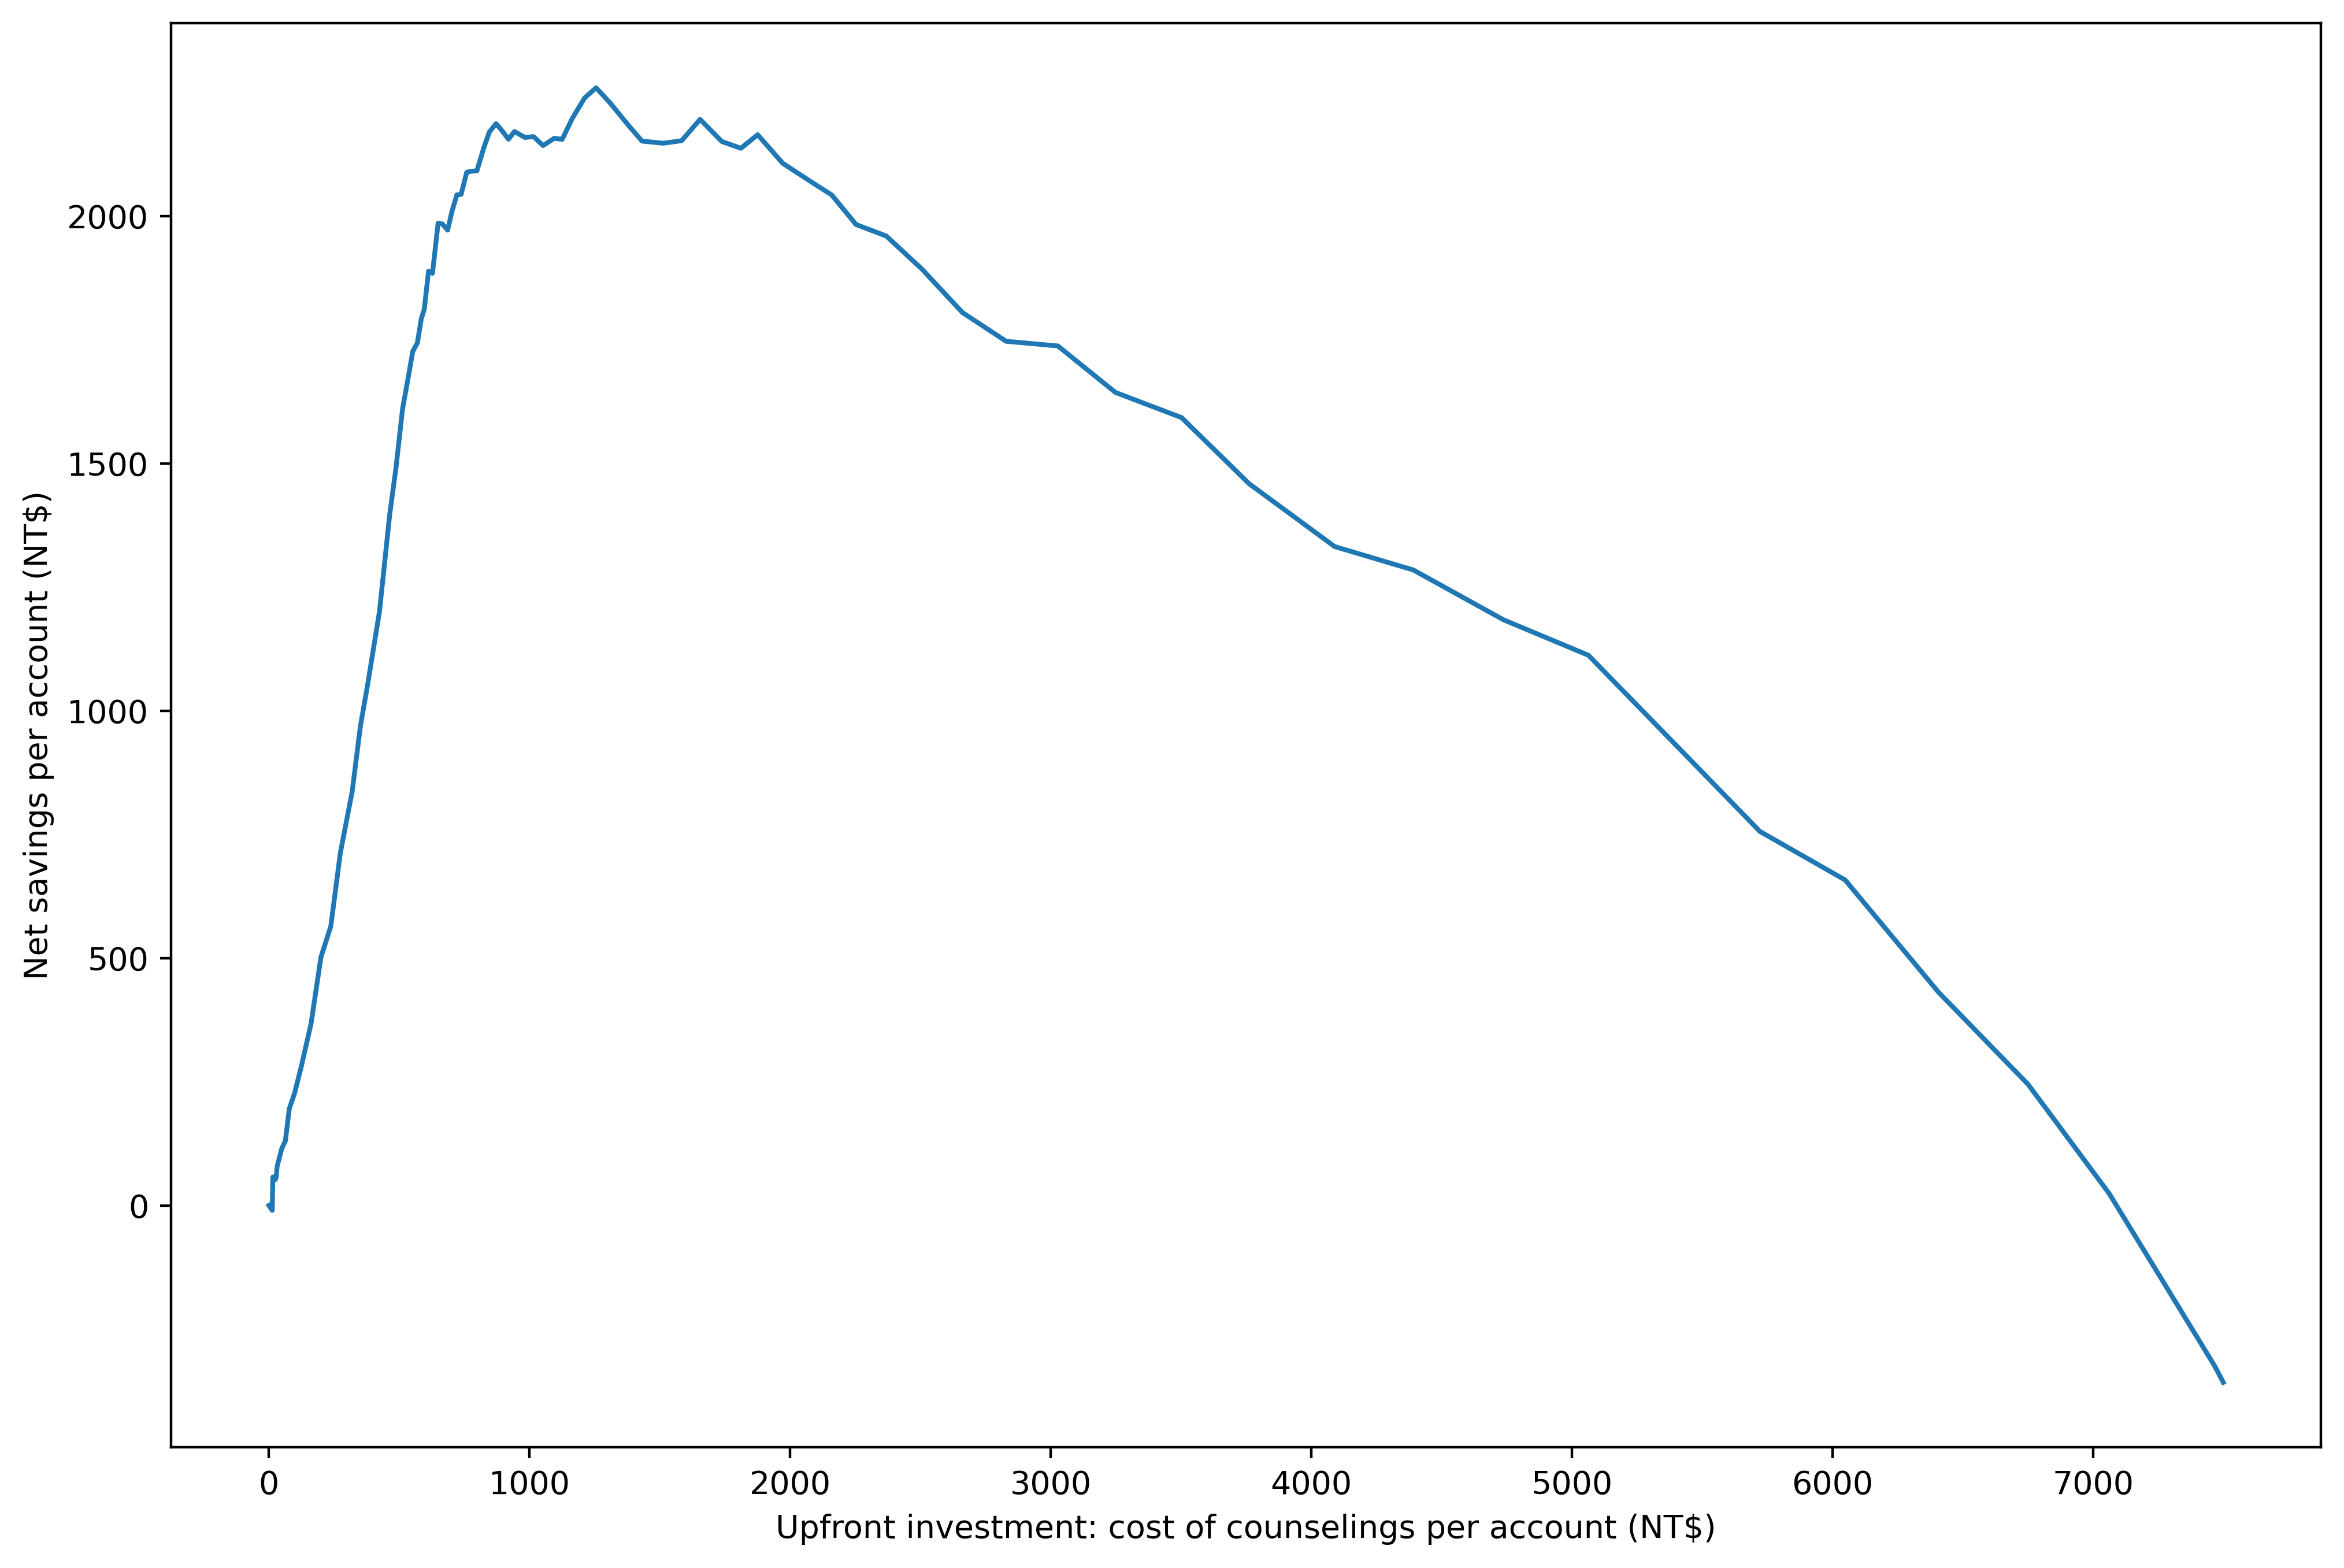

In [57]:
plt.figure(figsize=(12,8))
plt.plot(total_cost / len(y_test_all),
         net_savings / len(y_test_all))
plt.xlabel('Upfront investment: cost of counselings per account (NT$)')
plt.ylabel('Net savings per account (NT$)')

Text(0, 0.5, 'Flag rate')

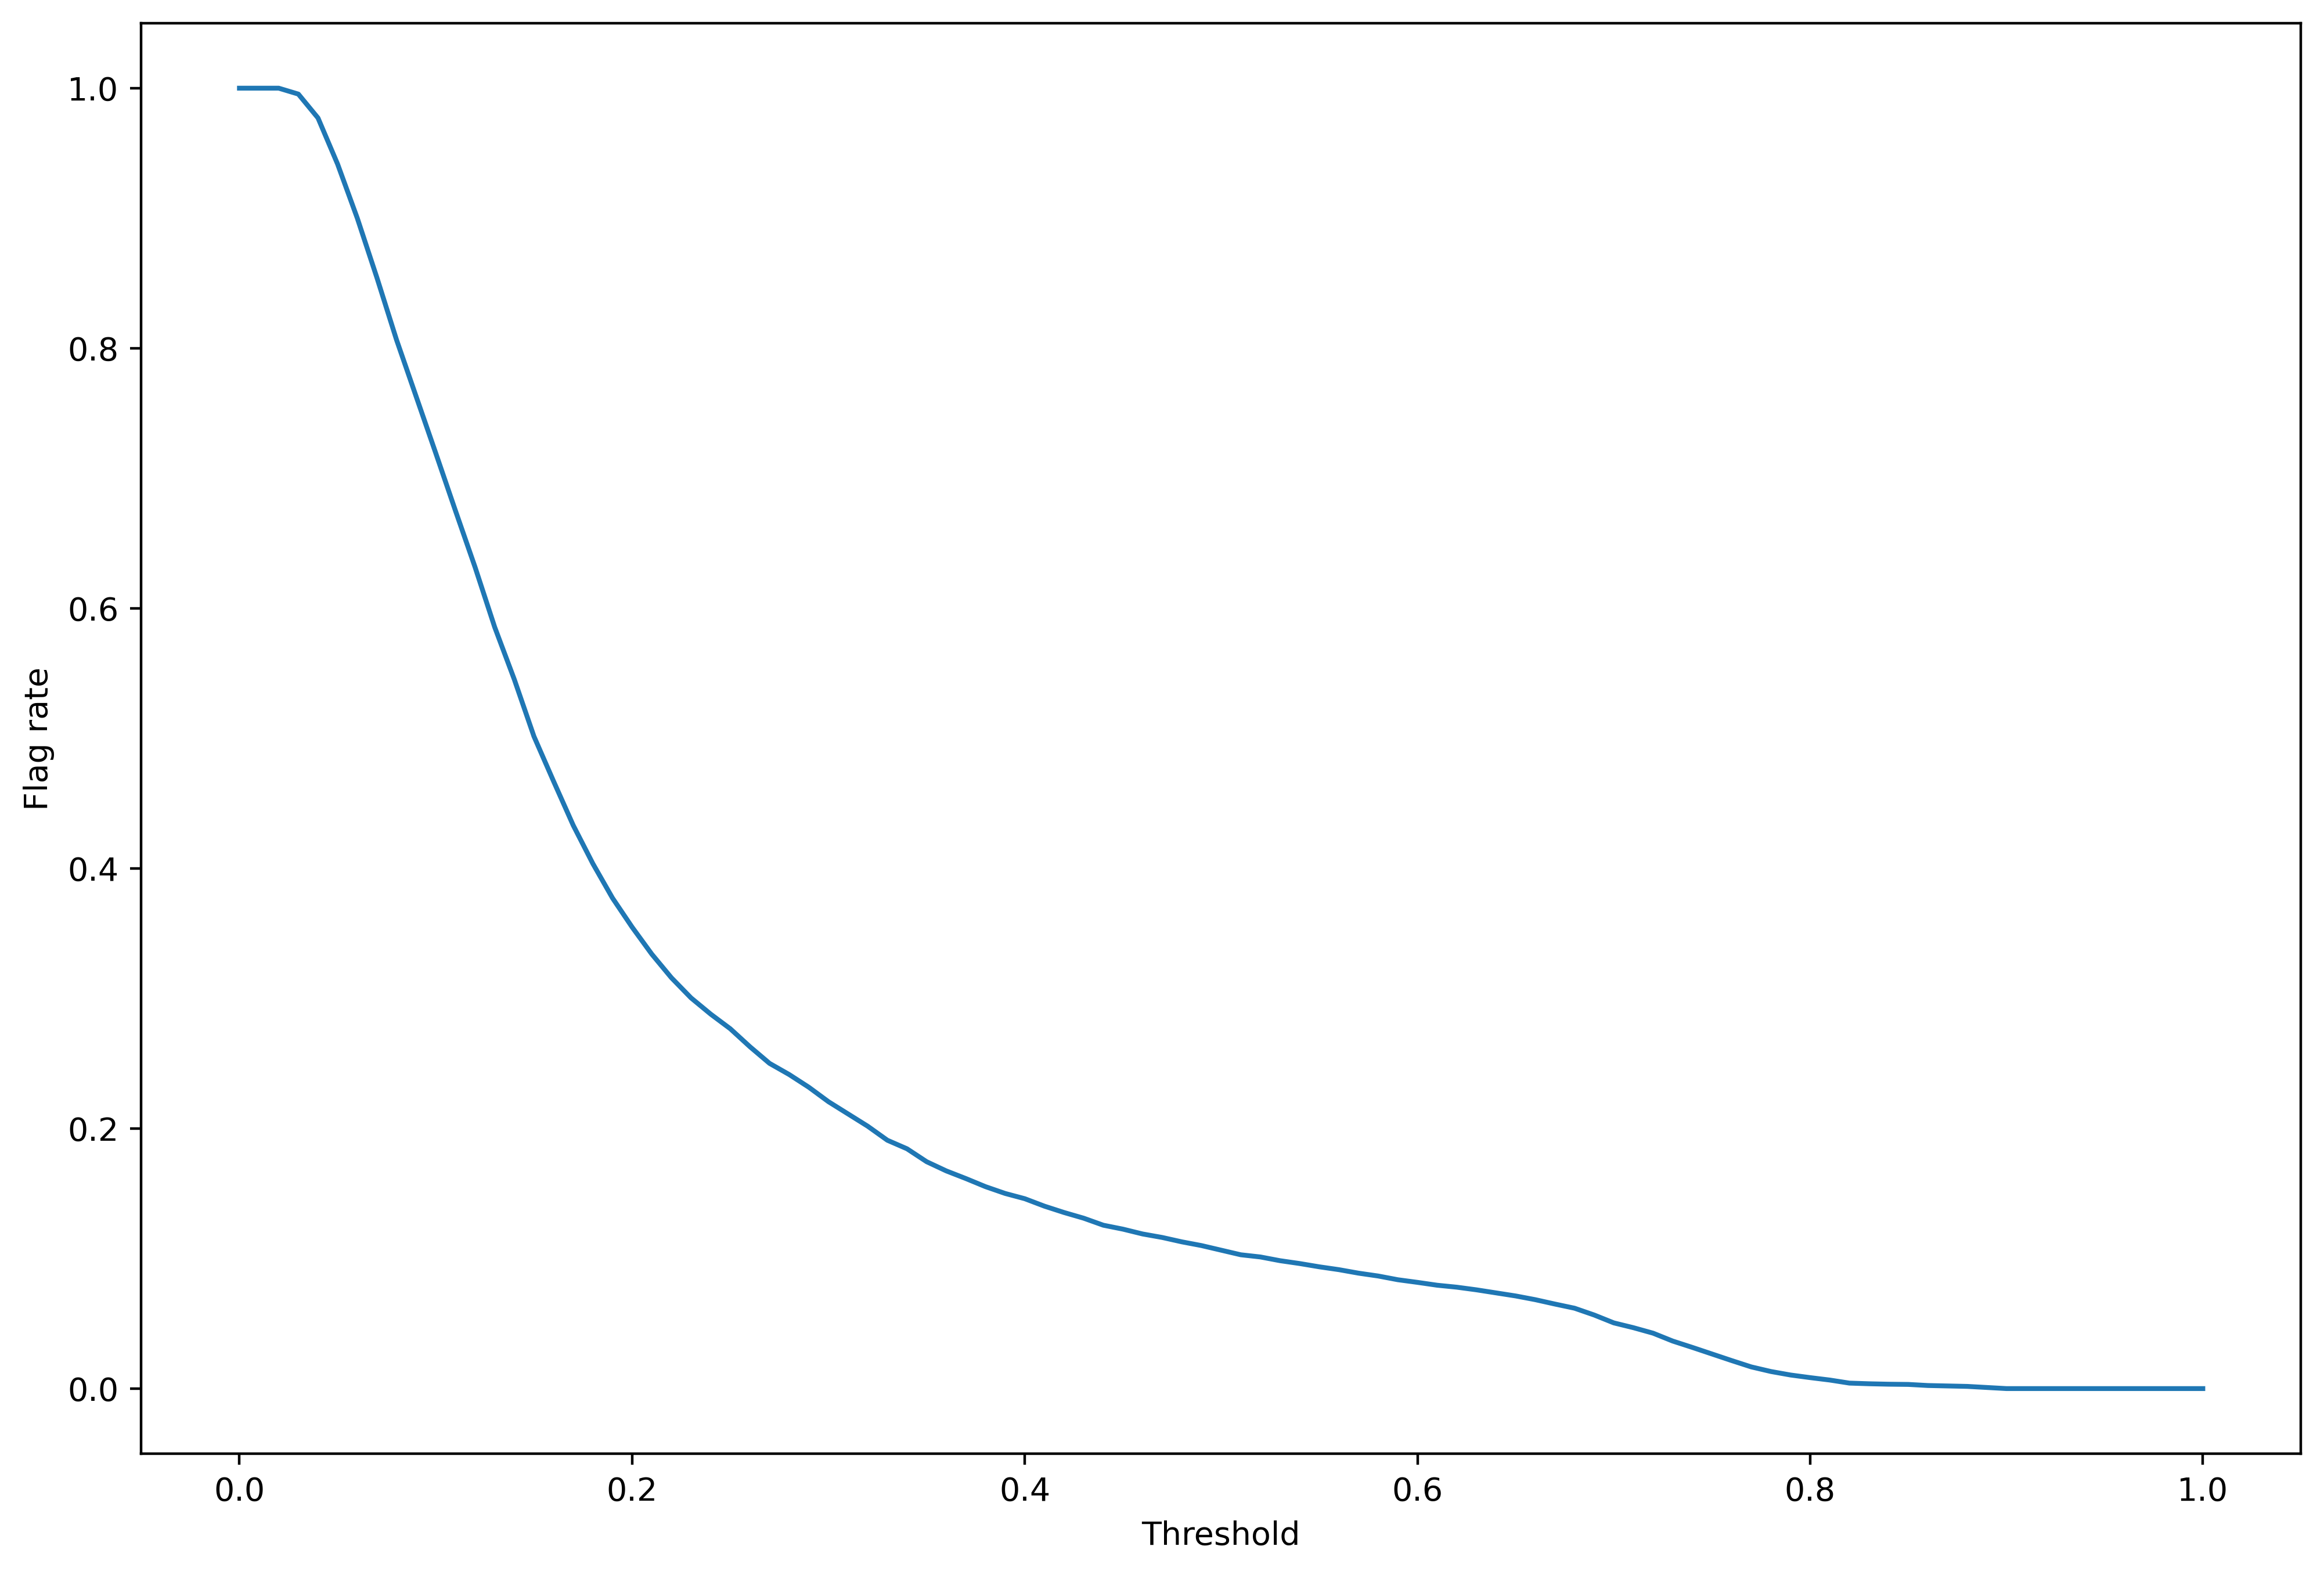

In [61]:
plt.figure(figsize=(12,8))
plt.plot(thresholds,
         n_pos_pred/len(y_test_all))
plt.xlabel('Threshold')
plt.ylabel('Flag rate')

invalid value encountered in divide


Text(0, 0.5, 'Precision')

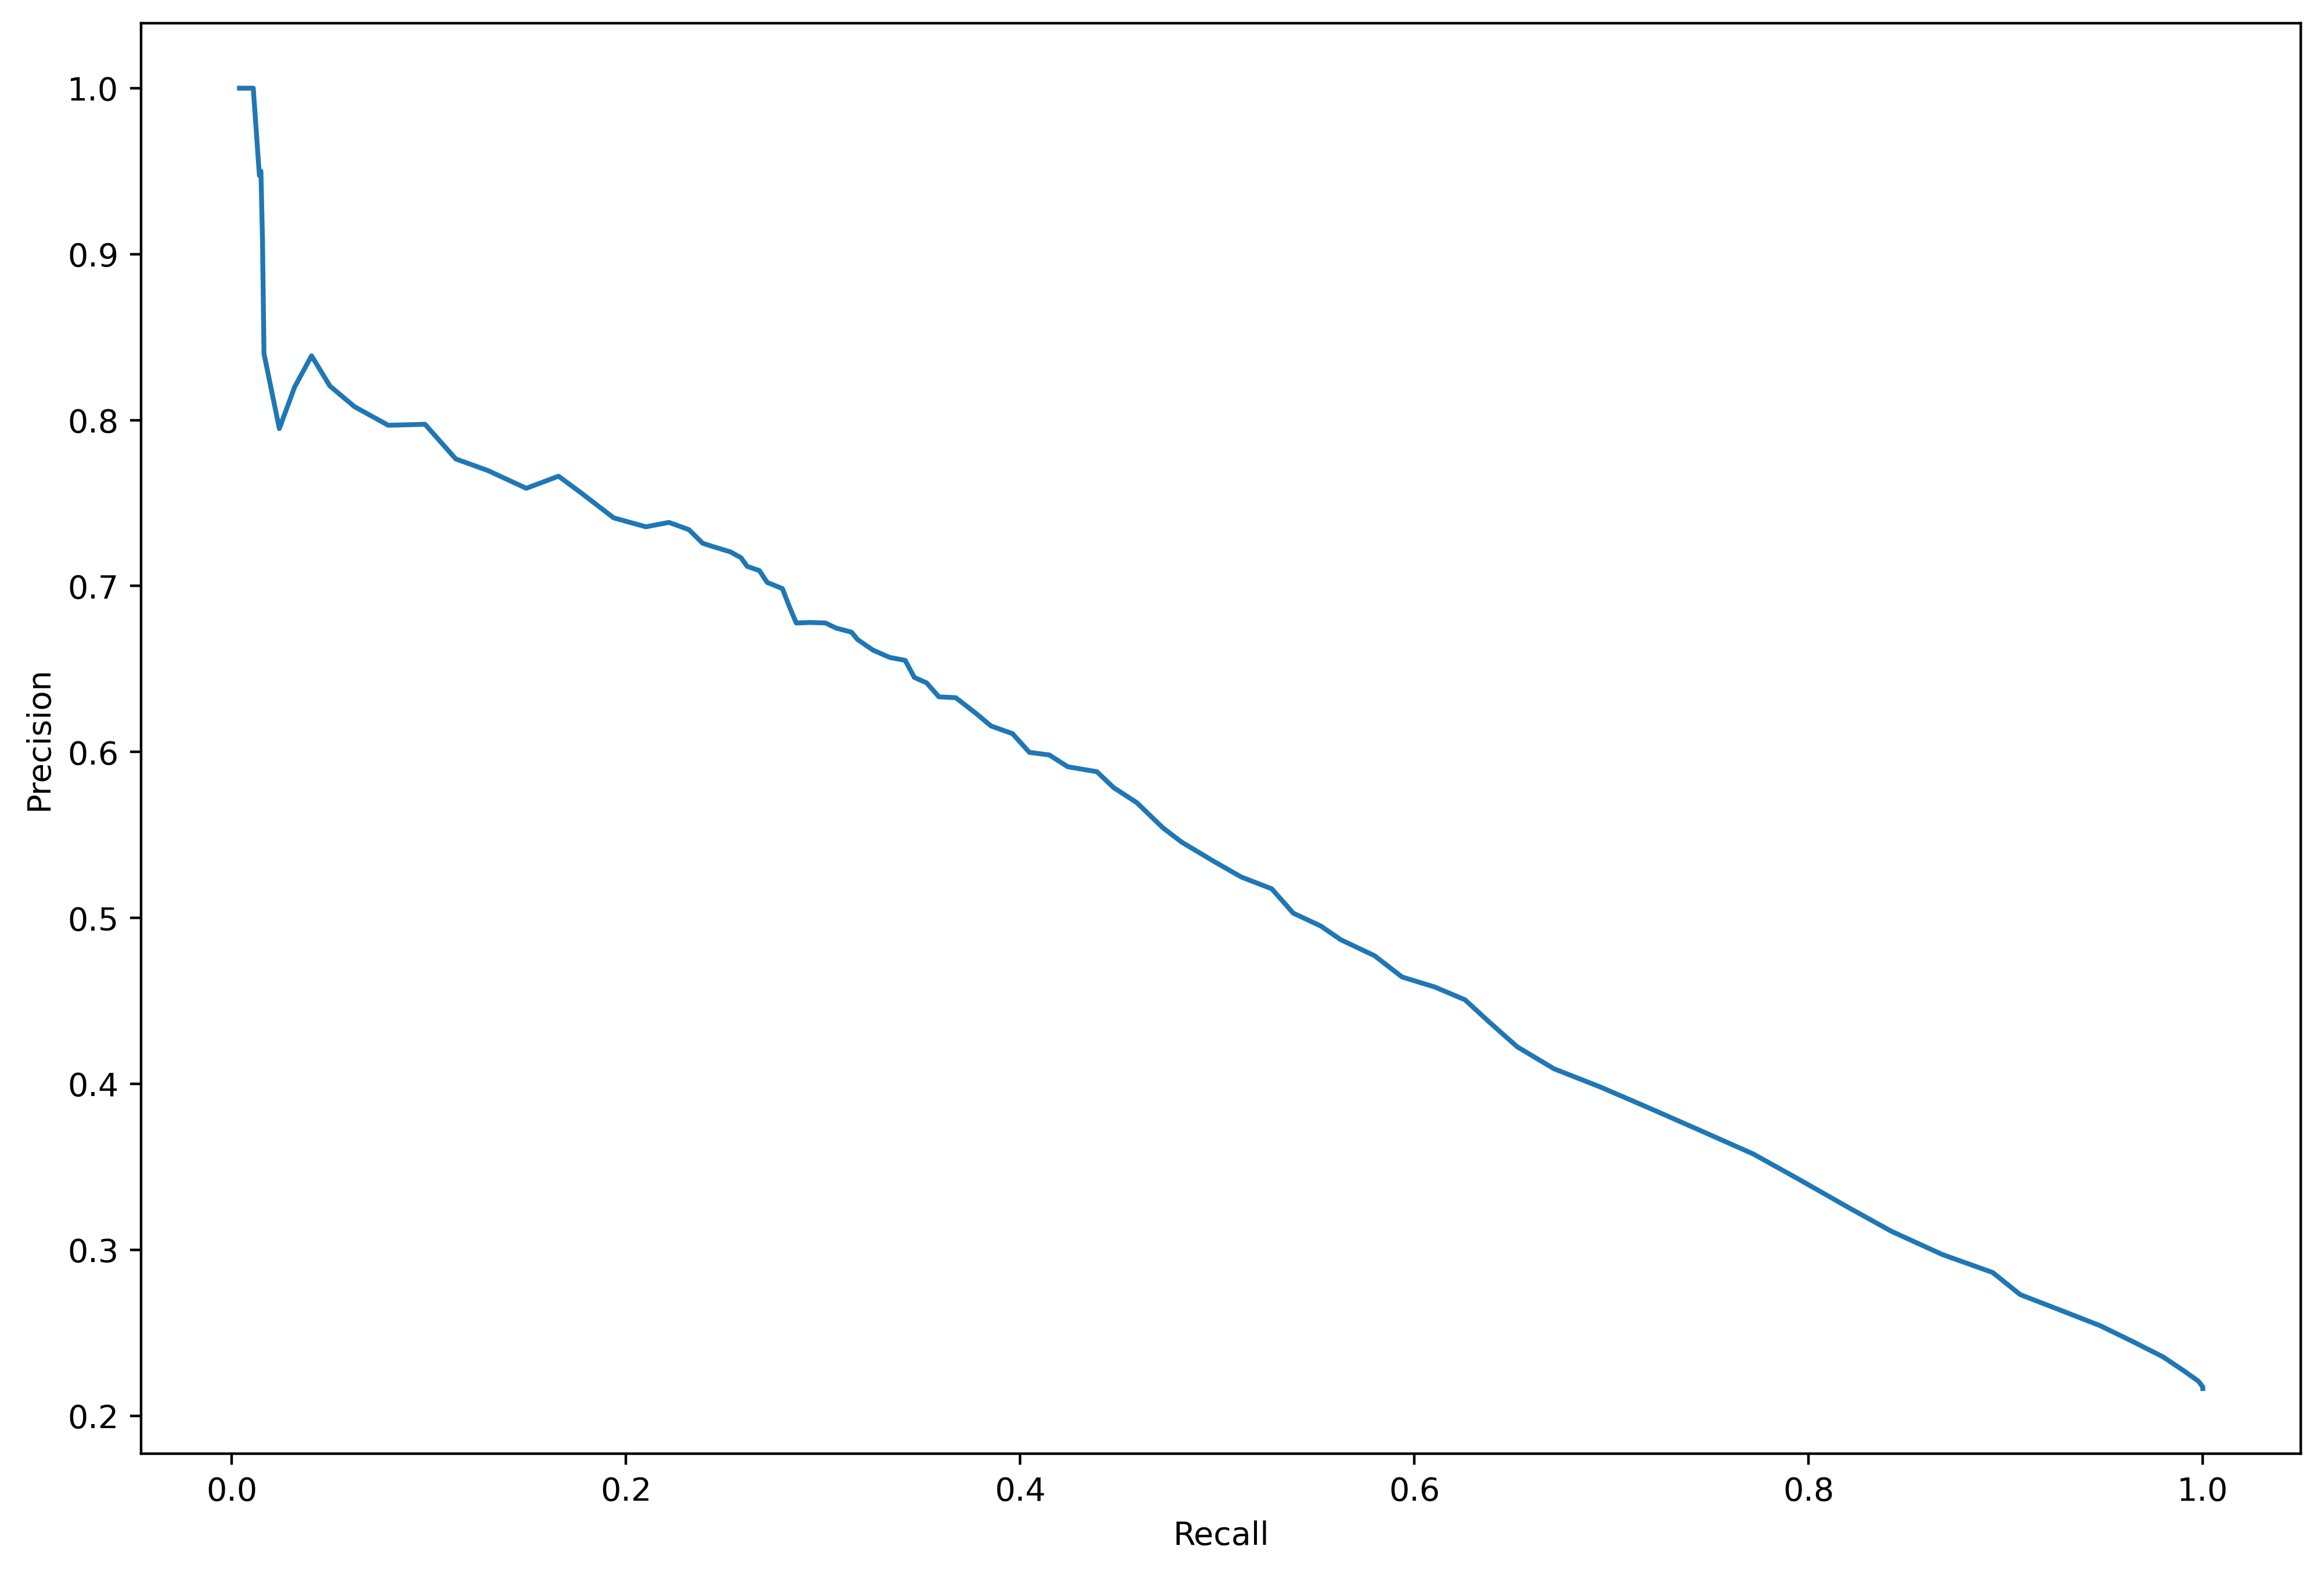

In [59]:
plt.figure(figsize=(12,8))
plt.plot(n_true_pos/sum(y_test_all),
         np.divide(n_true_pos, n_pos_pred))
plt.xlabel('Recall')
plt.ylabel('Precision')

invalid value encountered in divide


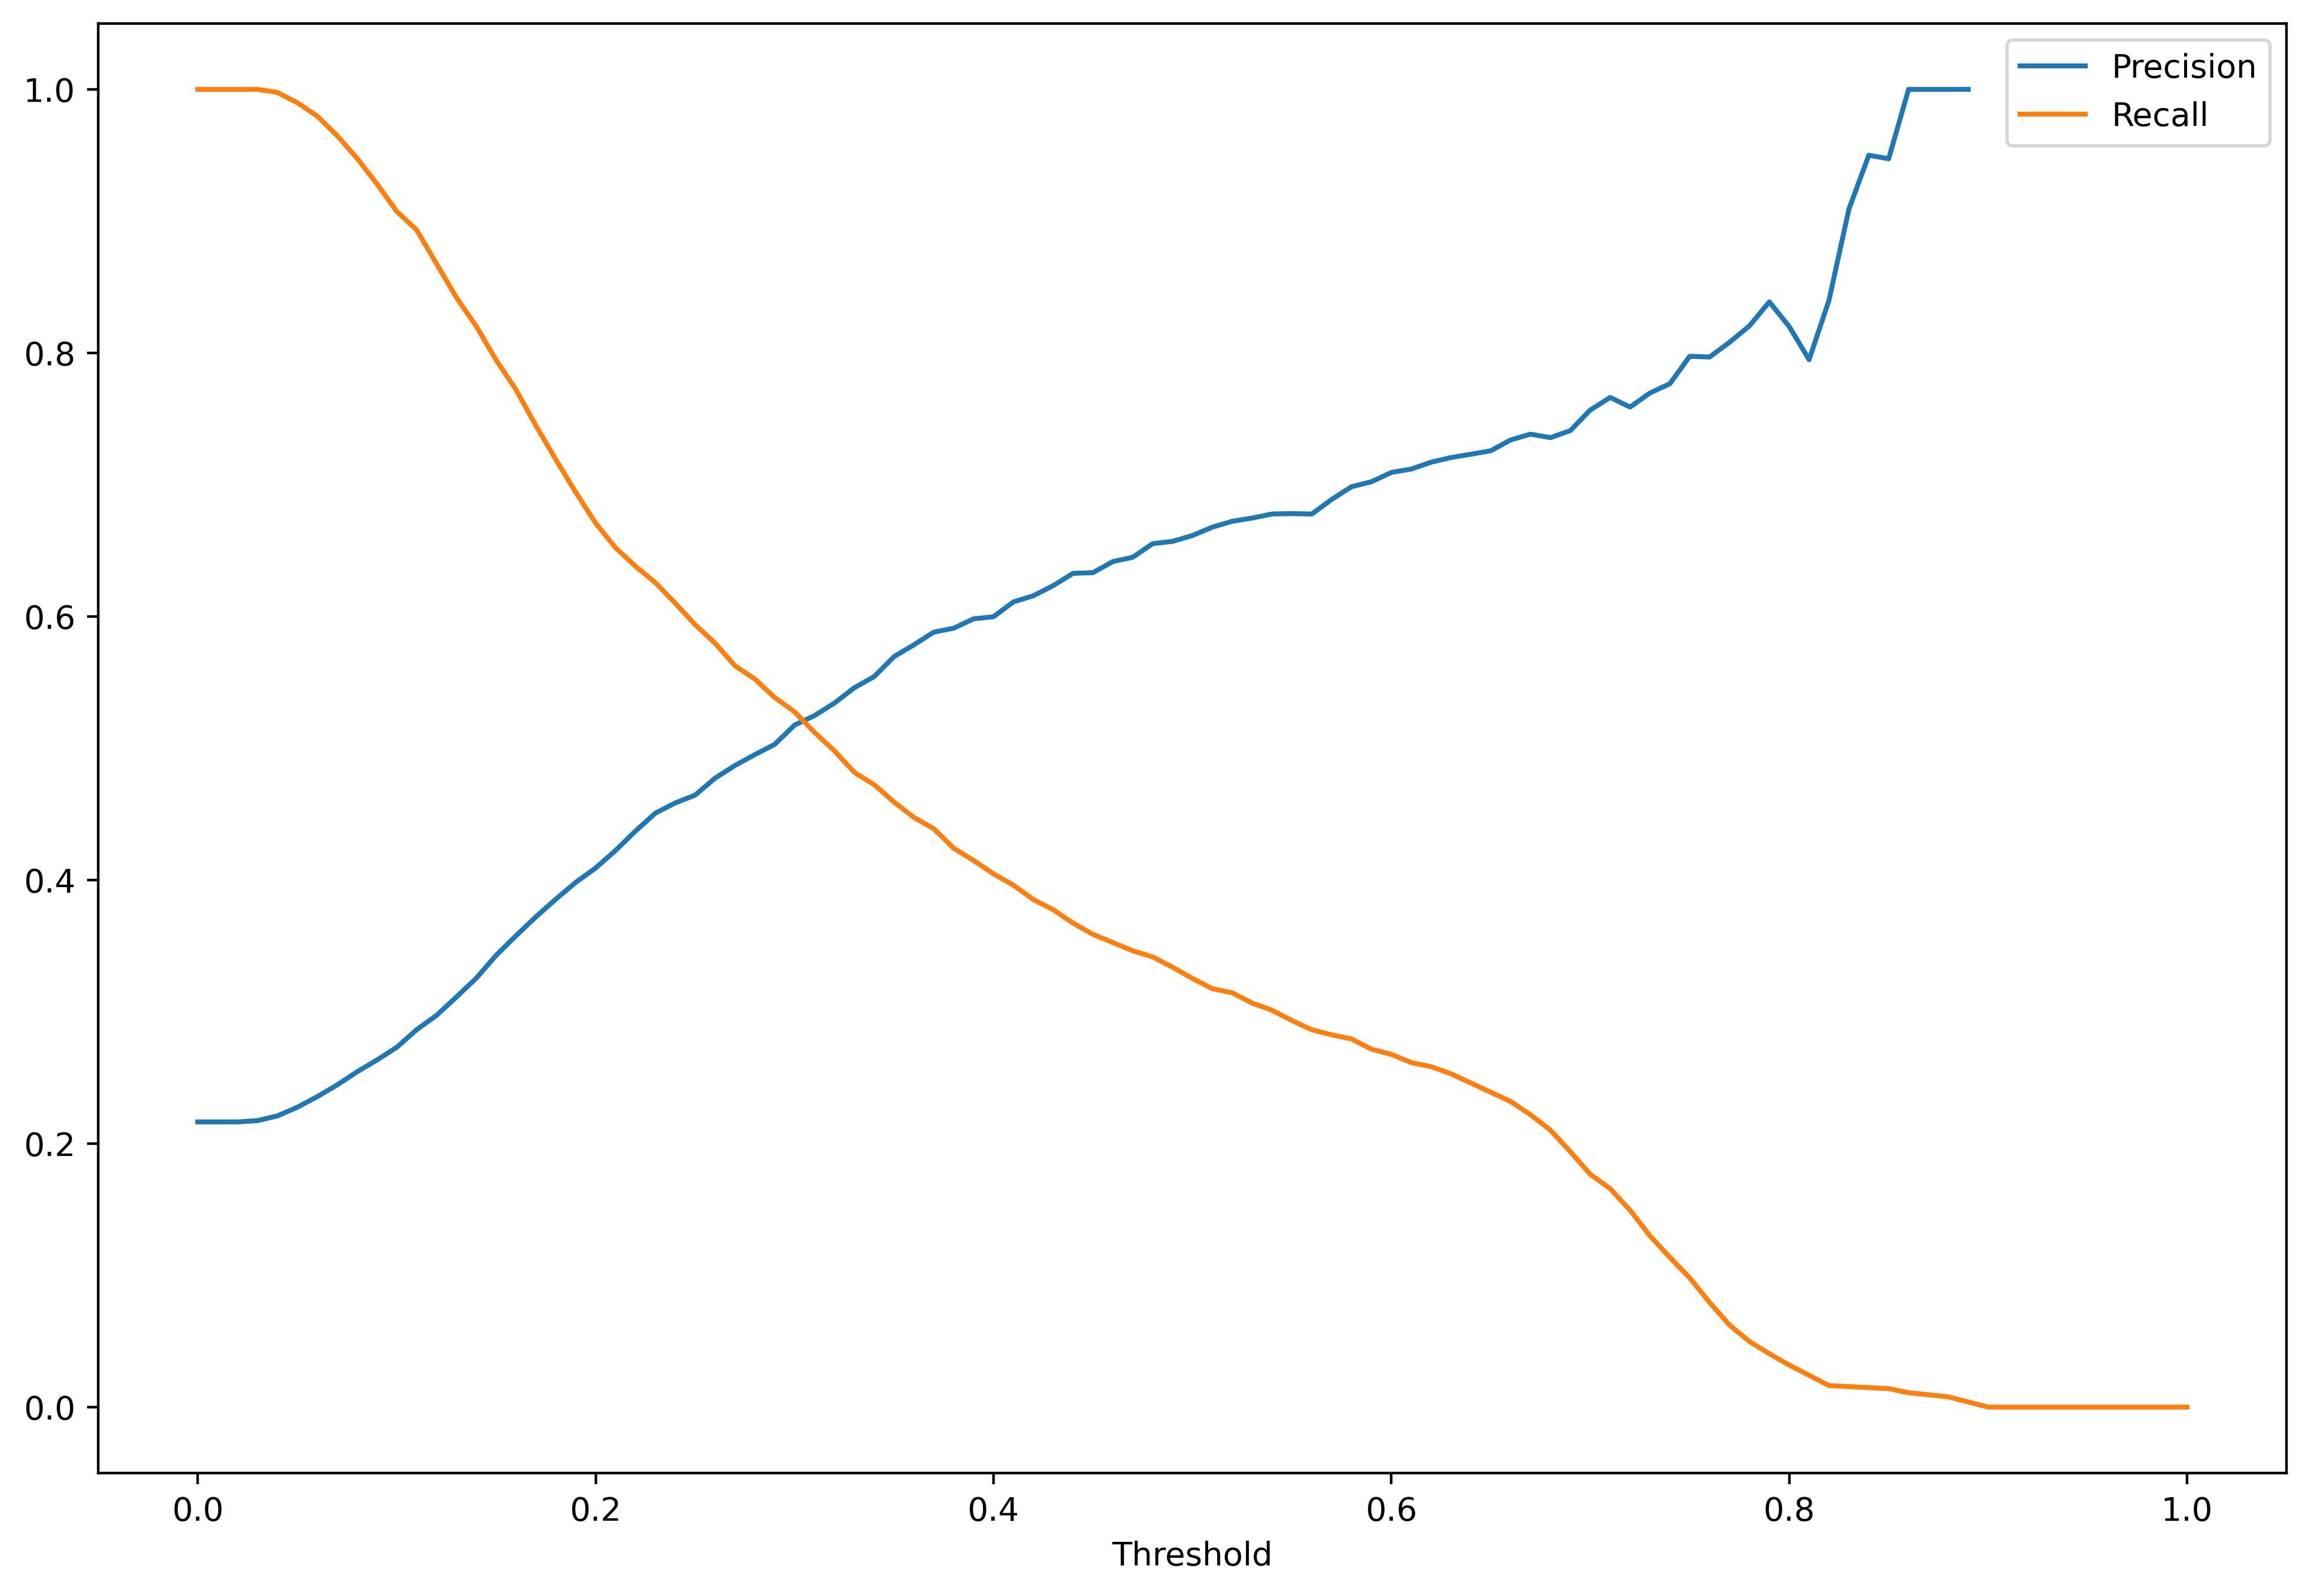

In [60]:
plt.figure(figsize=(12,8))
plt.plot(thresholds, np.divide(n_true_pos,n_pos_pred), label='Precision')
plt.plot(thresholds, n_true_pos / sum(y_test_all), label='Recall')
plt.xlabel('Threshold')
plt.legend()